## Hola!

 This document contains the Python code for the Image Analysis for the Grinding Operation Project, a project brought forth by the MASTeR Lab; Prof. Barbara Linke, Associate Professor in Mechanical and Aerospace Engineering, University of California, Davis.


This document was authored by Abdul-Hakeem Omotayo, Xiancheng Lin, and Xuezhen Li

## **How To Use This File**

Please follow the instructions below to set up Python and all dependencies

1. Download and install the latest version of Python here https://www.python.org/downloads/

2. Install PIP https://pip.pypa.io/en/stable/installation/. if you installed python from step 1, you should have PIP automatically installed too.

3. Install any of Jupyterlab or Jupyter Notebook https://jupyter.org/install

4. Download Linke_Data_shared from Dropbox. The folder containing the data must be named Linke_Data_shared.

5. Choose or create a folder you want all project artefact to be stored in, say, Favorite Folder Location. Then, set up a folder structure as below.


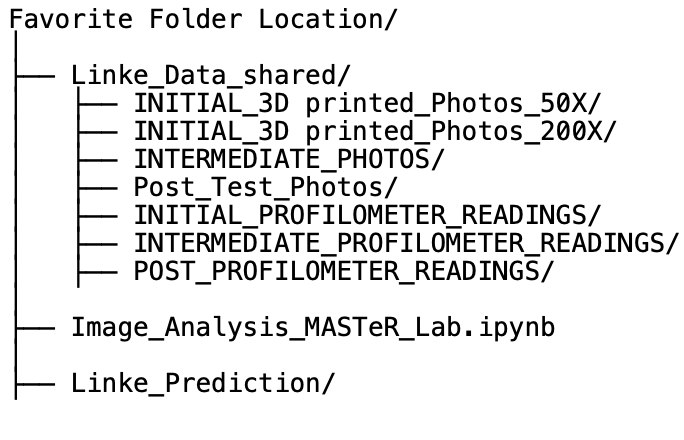

<!-- Favorite Folder Location/
│ 
├── Linke_Data_shared/
│   ├── INITIAL_3D printed_Photos_50X/
│   ├── INITIAL_3D printed_Photos_200X/
│   ├── INTERMEDIATE_PHOTOS/ 
│   ├── Post_Test_Photos/
│   ├── INITIAL_PROFILOMETER_READINGS/
│   ├── INTERMEDIATE_PROFILOMETER_READINGS/ 
│   ├── POST_PROFILOMETER_READINGS/
│ 
├── Image_Analysis_MASTeR_Lab.ipynb
│ 
├── Linke_Prediction/
 -->


Note: Data folder i.e Linke_Data_shared must be at the same level as Image_Analysis_MASTeR_Lab.ipynb

6. Any new set of images that would be used in model building should be saved in the appropriate folder. The default folder is Linke_Prediction.

7. To predict response on new images, the last cell in this notebook contain an example



## **Load Modules**

In [4]:
%%capture
################################################################################
############           Install dependecies for the project              ########
################################################################################


# pip install --upgrade pip
# pip install numpy pandas opencv-python rpy2 openpyxl matplotlib gitpython requests scikit-image scikit-learn statsmodels

In [5]:
%%capture

# import Python modules

import gzip, os

import numpy as np
import pandas as pd


from os import walk
from glob import glob


## **Download and Unpack Files Using**

In [6]:
######  %%capture # capture all output. Nothing will be displayed. Uncomment to display cell output


################################################################################
############           Download files from Google Drive Using R         ########
################################################################################


###### Uncomment cell if Linke_Data_shared folder is not available
###### The folder will be downloaded from google drive as a zip file
######  The content downloaded only contains all the files provided by MASTeR Lab as of 03-13-2022


# %load_ext rpy2.ipython # load R into Python

# %%R

# h = install.packages("pacman")
# h = library(pacman)
# p_load("tidyverse", "googledrive")

# downloading data

# drive_deauth()
# drive_user()
# public_file = drive_get(as_id("17TsDWM-Ug8mQuSqEp-6zn_W1raMdNgiV"))
# drive_download(public_file, overwrite = T)

## **Unzipping File**

In [7]:
# %%capture

# if on google colab
# !unzip "/content/Linke_Data_shared.zip" -d "/content/"

# !unzip "Linke_Data_shared.zip"
# not_reading = glob("Linke_Data_shared/*.txt")
# if os.path.exists(not_reading[0]):
#   os.remove(not_reading[0])
# else:
#   print("Can not delete the file as it doesn't exists")

## **Functions for data preprocessing**

In [8]:

def extract_excel(file):
    
    """
    
    Task: Extract the profilometer readings from a .xlsx file.
    
    Argument:
            file: filepath to excel file.
            
    Return:
            entry_dict: dataframe of file metadata and values the extracted from excel file
            
    """
    
    profilometer_xlsx = pd.read_excel(io = file, sheet_name=1, header=None)
    entry_dict = {}
    for row in profilometer_xlsx.iloc[0:23,0]:
        val_vec = [item for item in row.split(" ") if item != ''][0:2]

        try:
            entry_dict[val_vec[0]] = [float(val_vec[1])]
        except:
            entry_dict[val_vec[0]] = [float("nan")] # For those with errors, set to NaN

    entry_dict  = pd.DataFrame.from_dict(entry_dict)
    meta_data_df = profilometer_metadata_namer(file)
    entry_dict = meta_data_df.join(entry_dict)
    return(entry_dict)

In [9]:

def extract_txt(file):
    
    """
    
    Task: Extract the profilometer readings from a .txt file.
    
    Argument:
            file: filepath to text file.
            
    Return:
            entry_dict: dataframe of file metadata and values the extracted from text file
            
    """
    
    profilometer_txt = pd.read_table(file)
    entry_dict = {}
    
    for pos,val in enumerate(profilometer_txt.iloc[16:39,0]):
        val_vec = [item for item in val.split(";") if item != ''][0:2]
        if pos == 12: # fixing double occurence of Rmr(c)
          val_vec[0] += "2"

        try:
            entry_dict[val_vec[0]] = [float(val_vec[1])]
        except:
            entry_dict[val_vec[0]] = [float("nan")]
  
    entry_dict  = pd.DataFrame.from_dict(entry_dict)
    meta_data_df = profilometer_metadata_namer(file)
    entry_dict = meta_data_df.join(entry_dict)
    return(entry_dict)

In [10]:

def profilometer_metadata_namer(file):
    
    """
    
    Task:   Create metadata for file.
    
    Argument:
            file: filepath.
            
    Return:
            meta_data_df: dataframe of file metadata
            
    """

    file_id = file.split("/")[-1].split(".")[0].split("_")
    file_snap_time = file.split("/")[1].split("_")[0]
    if file_snap_time == "INTERMEDIATE":
        if file_id[0] == "01":
          file_id[0] = "0"
        meta_data_df = pd.DataFrame({"Capturetime": file_snap_time, "Buildangle":[file_id[0]], "Facenumber": [file_id[1]], "Measurementnum": [file_id[2]]})
    else:
        meta_data_df = pd.DataFrame({"Capturetime": file_snap_time, "Buildangle":[file.split("/")[-2].split("_")[0]], "Facenumber": [file_id[0]], "Measurementnum": [file_id[1]]})
    return(meta_data_df)

## **Read all profilometer readings found in the Linke_Data_shared**

In [11]:
################################################################################
####### Read all profilometer readings found in the Linke_Data_shared   ########
################################################################################


prof_filenames = glob("Linke_Data_shared/**/*.TXT", recursive=True) + glob("Linke_Data_shared/**/*.xlsx", recursive=True)
print("{} TXT and XLSX files matched".format(len(prof_filenames)))
img_profilometer_data =[]
processed = 0
alternates = 0
pd_file = []
for pos,file in enumerate(prof_filenames):

  if "Alternate" in file: # ignoring profilometer filenames that has alternate
    alternates += 1
    continue
  if ".TXT" in file:
    profile_readings = extract_txt(file)
    profile_readings.rename(columns={"Rku": "Rkmu", "Rmr(c)": "Rmr(c)1"}, inplace=True)
    processed += 1
  else:
    profile_readings = extract_excel(file)
    profile_readings.rename(columns={"Rkµ": "Rkmu"}, inplace=True)
    processed += 1
  if pos > 0:
    img_profilometer_data = pd.concat([img_profilometer_data,profile_readings])
  else: 
    img_profilometer_data = profile_readings
  pd_file.append(file)
  if ((pos+1) % 20  == 0 or pos == len(prof_filenames) - 1):
    print("Processed {0} out of {1} profilometer readings. File id: {2}".format(processed, len(prof_filenames), file.split("/")[-1]))
img_profilometer_data["ProfileFilepath"] =  pd_file   
print()
print()
print("Finished processing all {} profilometer readings excluding {} alternates".format(processed, alternates))

306 TXT and XLSX files matched
Processed 20 out of 306 profilometer readings. File id: 5_6.TXT
Processed 40 out of 306 profilometer readings. File id: 4_4.TXT
Processed 60 out of 306 profilometer readings. File id: 3_3.TXT
Processed 80 out of 306 profilometer readings. File id: 2_1.TXT
Processed 100 out of 306 profilometer readings. File id: 1_4.TXT
Processed 120 out of 306 profilometer readings. File id: 1_2.xlsx
Processed 140 out of 306 profilometer readings. File id: 6_4.xlsx
Processed 164 out of 306 profilometer readings. File id: 2_5.xlsx
Processed 184 out of 306 profilometer readings. File id: 5_3.xlsx
Processed 204 out of 306 profilometer readings. File id: 2_4.xlsx
Processed 224 out of 306 profilometer readings. File id: 01_4_4.xlsx
Processed 244 out of 306 profilometer readings. File id: 01_4_1.xlsx
Processed 264 out of 306 profilometer readings. File id: 01_3_4.xlsx
Processed 270 out of 306 profilometer readings. File id: 90_2_5.xlsx


Finished processing all 270 profilometer

## **Read all images found in the Linke_Data_shared**

In [12]:
################################################################################
#######         Read all images found in the Linke_Data_shared          ########
################################################################################


img_filenames = glob("Linke_Data_shared/**/*.jpg", recursive=True)
print("{} JPG images matched".format(len(prof_filenames)))
magnif, buildangle, facenumber, file_snap_times, filepaths = [], [], [], [], []
for pos,img_file in enumerate(img_filenames):
  if ((pos+1) % 10  == 0 or pos == len(img_filenames) - 1):
    print("Processing {0} out of {1} Grinding tool image. Filepath: {2}".format(pos + 1, len(img_filenames), img_file))
  file_snap_time = img_file.split("/")[1].split("_")[0].upper()
  try:
    if file_snap_time == "INITIAL":
      file_id = img_file.split("/")[-1].split(".")[0].split("_")
      if "A" in file_id[1]: # ignoring images that are alternate
            continue
      else:
          facenumber.append(file_id[1])
      buildangle.append(file_id[0])
      magnif.append(img_file.split("/")[1].split("_")[-1][:-1]) 
      filepaths.append(img_file)
      file_snap_times.append(file_snap_time)
    elif  file_snap_time == "INTERMEDIATE":
      file_id = img_file.split("/")[-1].split(".")[0].split("_")
      if "A" in file_id[1]: # ignoring images that are alternate
            continue
      else:
          facenumber.append(file_id[1])    
      magnif.append(file_id[3])
      buildangle.append(file_id[2])
      filepaths.append(img_file)
      file_snap_times.append(file_snap_time)       
    elif  file_snap_time == "POST":
      file_id = img_file.split("/")[-1].split(".")[0].split("_")
      if "A" in file_id[1]: # ignoring images that are alternate
            continue
      else:
          facenumber.append(file_id[1])
      magnif.append(file_id[2])
      buildangle.append(file_id[0])
      filepaths.append(img_file)
      file_snap_times.append(file_snap_time)
    else:
      print("Error: Bad file: {}".format(img_file))
  except:
      print("Something went wrong while processing file: {}".format(img_file))
    
print("\n\n\nFinished processing all files")
img_metadata = pd.DataFrame({"Capturetime": file_snap_times, "Buildangle":buildangle, "Facenumber": facenumber, "Zoom": magnif, "ImgFilepath": filepaths})
print(img_metadata.shape)

306 JPG images matched
Processing 10 out of 104 Grinding tool image. Filepath: Linke_Data_shared/INITIAL_3D printed_Photos_50X/15_5A.jpg
Something went wrong while processing file: Linke_Data_shared/INITIAL_3D printed_Photos_50X/200X.jpg
Something went wrong while processing file: Linke_Data_shared/INITIAL_3D printed_Photos_50X/50X.jpg
Processing 20 out of 104 Grinding tool image. Filepath: Linke_Data_shared/INITIAL_3D printed_Photos_50X/0_1.jpg
Processing 30 out of 104 Grinding tool image. Filepath: Linke_Data_shared/INITIAL_3D printed_Photos_200X/90_1.jpg
Processing 40 out of 104 Grinding tool image. Filepath: Linke_Data_shared/INITIAL_3D printed_Photos_200X/90_4.jpg
Processing 50 out of 104 Grinding tool image. Filepath: Linke_Data_shared/INITIAL_3D printed_Photos_200X/0_4.jpg
Processing 60 out of 104 Grinding tool image. Filepath: Linke_Data_shared/INTERMEDIATE_PHOTOS/1_2_90_200.jpg
Processing 70 out of 104 Grinding tool image. Filepath: Linke_Data_shared/Post_Test_Photos/15_3_200.

In [13]:

def aggregate_by_img(df):
    
    """
    
    Task:   Aggregate profilometer readings for each image.
            Mean is computed for continuous variable.
            Number (count) of entries is computed for categorical variable
    
    Argument:
            df: dataframe containing profilometer readings and the metadata for each profilometer.
            
    Return:
            df_agg: dataframe of aggregated data for each image
            
    """    
    
    agg_arg = {}
    col_names = df.columns[3:]
    for col in col_names:
        agg_arg[col] = 'mean'
        if col == 'Measurementnum' :
           agg_arg[col] = "count"
        if col == "ProfileFilepath":
           agg_arg[col] = "first"       

    df_agg = df.groupby(["Capturetime", "Buildangle", "Facenumber"]).agg(agg_arg)
    print('Aggregated dataframe from {} to {}'.format(df.shape, df_agg.shape))
    return df_agg

## **Display  some images and profilometer metadata** 

In [14]:
################################################################################
#######             Display  some images metadata                       ########
################################################################################


display(img_metadata.head())
print(img_metadata.shape)


################################################################################
#######             Display  some profilometer metadata                 ########
################################################################################

display(img_profilometer_data.head())
print(img_profilometer_data.shape)

,Capturetime,Buildangle,Facenumber,Zoom,ImgFilepath
0,INITIAL,15,1,50,Linke_Data_shared/INITIAL_3D printed_Photos_50...
1,INITIAL,90,1,50,Linke_Data_shared/INITIAL_3D printed_Photos_50...
2,INITIAL,15,2,50,Linke_Data_shared/INITIAL_3D printed_Photos_50...
3,INITIAL,90,2,50,Linke_Data_shared/INITIAL_3D printed_Photos_50...
4,INITIAL,90,3,50,Linke_Data_shared/INITIAL_3D printed_Photos_50...


(90, 5)


,Capturetime,Buildangle,Facenumber,Measurementnum,Ra,Rq,Rz,Rp,Rv,Rsk,...,Rt,Rz1max,Rk,Rpk,Rvk,Mr1,Mr2,A1,A2,ProfileFilepath
0,POST,0,4,5,0.936,1.113,5.010,2.510,2.500,0.085,...,8.356,8.356,3.205,1.177,1.296,4.825,90.463,2.84,6.18,Linke_Data_shared/POST_PROFILOMETER_READINGS/0...
0,POST,0,2,3,1.041,1.319,7.159,3.065,4.094,-0.213,...,9.655,9.655,3.296,1.158,1.526,9.725,88.163,5.63,9.03,Linke_Data_shared/POST_PROFILOMETER_READINGS/0...
0,POST,0,2,2,0.856,1.068,5.469,2.755,2.714,0.003,...,6.109,5.850,2.812,0.990,1.032,9.163,88.588,4.53,5.89,Linke_Data_shared/POST_PROFILOMETER_READINGS/0...
0,POST,0,4,4,1.325,1.636,7.375,3.797,3.578,0.107,...,9.683,9.201,4.583,1.222,1.818,7.425,91.150,4.54,8.05,Linke_Data_shared/POST_PROFILOMETER_READINGS/0...
0,POST,0,6,6,0.627,0.767,3.670,1.739,1.931,-0.311,...,5.302,5.129,2.323,0.564,0.894,4.863,92.788,1.37,3.22,Linke_Data_shared/POST_PROFILOMETER_READINGS/0...


(270, 28)


In [15]:
################################################################################
####      Aggregate the profilometer reading into a new dataframe          #####
################################################################################

img_profilometer_data_agg = aggregate_by_img(img_profilometer_data)

display(img_profilometer_data_agg.head())
print(img_profilometer_data_agg.shape)

Aggregated dataframe from (270, 28) to (45, 25)


Measurementnum         Ra         Rq  \
Capturetime Buildangle Facenumber                                         
INITIAL     0          1                        6  10.499167  12.731500   
                       2                        6   8.166000   9.922167   
                       3                        6   7.782333   9.464333   
                       4                        6  10.656500  12.995333   
                       5                        6   8.966833  10.759000   

                                          Rz         Rp         Rv       Rsk  \
Capturetime Buildangle Facenumber                                              
INITIAL     0          1           54.209833  26.111167  28.099167  0.005000   
                       2           42.816167  18.342667  24.473667 -0.137667   
                       3           41.082833  18.357000  22.725833 -0.022167   
                       4           56.136667  25.049833  31.087000 -0.113167   
                       5           44.188167  18.269667  25.918500 -0.376333   

                                       Rkmu         Rc         RSm  ...  \
Capturetime Buildangle Facenumber                                   ...   
INITIAL     0          1           2.420833  37.747833  651.733333  ...   
                       2           2.665000  30.423333  573.216667  ...   
                       3           2.696667  29.086833  646.416667  ...   
                       4           2.674500  45.149750  487.525000  ...   
                       5           2.408000  50.098333  265.400000  ...   

                                          Rt     Rz1max         Rk        Rpk  \
Capturetime Buildangle Facenumber                                               
INITIAL     0          1           64.669667  61.190000  34.614833  10.169333   
                       2           49.012667  48.569000  24.210333   5.486833   
                       3           48.422167  46.929000  21.564500   6.964833   
                       4           87.152167  86.141667  32.705000  13.023000   
                       5           51.705333  50.941167  26.947833   6.619500   

                                         Rvk       Mr1        Mr2         A1  \
Capturetime Buildangle Facenumber                                              
INITIAL     0          1            9.619500  9.061500  90.034167  46.680000   
                       2           11.520167  8.303333  85.054167  21.266667   
                       3           11.933167  9.325833  84.703667  29.313333   
                       4           17.150000  7.961167  86.030333  50.685000   
                       5           12.603667  6.216500  84.417833  19.380000   

                                           A2  \
Capturetime Buildangle Facenumber               
INITIAL     0          1            47.950000   
                       2           104.766667   
                       3           115.048333   
                       4           117.515000   
                       5           108.378333   

                                                                     ProfileFilepath  
Capturetime Buildangle Facenumber                                                     
INITIAL     0          1           Linke_Data_shared/INITIAL_PROFILOMETER_READING...  
                       2           Linke_Data_shared/INITIAL_PROFILOMETER_READING...  
                       3           Linke_Data_shared/INITIAL_PROFILOMETER_READING...  
                       4           Linke_Data_shared/INITIAL_PROFILOMETER_READING...  
                       5           Linke_Data_shared/INITIAL_PROFILOMETER_READING...  

[5 rows x 25 columns]

(45, 25)


In [16]:

##########################################################################################################
#### Merge (only intersection) profilometer dataset with corresponding images. One reading per image #####
####                Dispay merged dataset including number of rows and columns                       #####
##########################################################################################################

grinding_img_dataset = pd.merge(left = img_profilometer_data, right = img_metadata, how = "inner", on= ["Capturetime", 'Buildangle','Facenumber'], indicator = True)

display(grinding_img_dataset)
print(grinding_img_dataset.shape)

##########################################################################################################################
####   Merge (only intersection) aggregated profilometer dataset with corresponding images. One reading per image    #####
####                          Dispay merged dataset including number of rows and columns                             #####
##########################################################################################################################

grinding_img_agg_dataset = pd.merge(left = img_profilometer_data_agg, right = img_metadata, how = "inner", on= ["Capturetime", 'Buildangle','Facenumber'], indicator = True)

display(grinding_img_agg_dataset)
print(grinding_img_agg_dataset.shape)

,Capturetime,Buildangle,Facenumber,Measurementnum,Ra,Rq,Rz,Rp,Rv,Rsk,...,Rpk,Rvk,Mr1,Mr2,A1,A2,ProfileFilepath,Zoom,ImgFilepath,_merge
0,POST,0,4,5,0.936,1.113,5.010,2.510,2.500,0.085,...,1.177,1.296,4.825,90.463,2.84,6.18,Linke_Data_shared/POST_PROFILOMETER_READINGS/0...,50,Linke_Data_shared/Post_Test_Photos/0_4_50.jpg,both
1,POST,0,4,5,0.936,1.113,5.010,2.510,2.500,0.085,...,1.177,1.296,4.825,90.463,2.84,6.18,Linke_Data_shared/POST_PROFILOMETER_READINGS/0...,200,Linke_Data_shared/Post_Test_Photos/0_4_200.jpg,both
2,POST,0,4,4,1.325,1.636,7.375,3.797,3.578,0.107,...,1.222,1.818,7.425,91.150,4.54,8.05,Linke_Data_shared/POST_PROFILOMETER_READINGS/0...,50,Linke_Data_shared/Post_Test_Photos/0_4_50.jpg,both
3,POST,0,4,4,1.325,1.636,7.375,3.797,3.578,0.107,...,1.222,1.818,7.425,91.150,4.54,8.05,Linke_Data_shared/POST_PROFILOMETER_READINGS/0...,200,Linke_Data_shared/Post_Test_Photos/0_4_200.jpg,both
4,POST,0,4,6,1.194,1.417,6.063,3.052,3.011,-0.085,...,1.357,1.442,14.425,90.763,9.79,6.66,Linke_Data_shared/POST_PROFILOMETER_READINGS/0...,50,Linke_Data_shared/Post_Test_Photos/0_4_50.jpg,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,INTERMEDIATE,0,3,2,9.584,12.401,65.522,26.982,38.539,-0.103,...,17.091,30.220,13.181,87.215,112.64,193.18,Linke_Data_shared/INTERMEDIATE_PROFILOMETER_RE...,50,Linke_Data_shared/INTERMEDIATE_PHOTOS/2_3_0_50...,both
536,INTERMEDIATE,0,3,5,4.070,5.118,24.285,11.420,12.866,-0.139,...,4.952,5.575,7.779,86.831,19.26,36.71,Linke_Data_shared/INTERMEDIATE_PROFILOMETER_RE...,200,Linke_Data_shared/INTERMEDIATE_PHOTOS/2_3_0_20...,both
537,INTERMEDIATE,0,3,5,4.070,5.118,24.285,11.420,12.866,-0.139,...,4.952,5.575,7.779,86.831,19.26,36.71,Linke_Data_shared/INTERMEDIATE_PROFILOMETER_RE...,50,Linke_Data_shared/INTERMEDIATE_PHOTOS/2_3_0_50...,both
538,INTERMEDIATE,0,3,4,4.579,5.747,26.281,12.353,13.928,-0.092,...,6.067,7.742,12.089,86.291,36.67,53.07,Linke_Data_shared/INTERMEDIATE_PROFILOMETER_RE...,200,Linke_Data_shared/INTERMEDIATE_PHOTOS/2_3_0_20...,both


(540, 31)


,Capturetime,Buildangle,Facenumber,Measurementnum,Ra,Rq,Rz,Rp,Rv,Rsk,...,Rpk,Rvk,Mr1,Mr2,A1,A2,ProfileFilepath,Zoom,ImgFilepath,_merge
0,INITIAL,0,1,6,10.499167,12.731500,54.209833,26.111167,28.099167,0.005000,...,10.169333,9.619500,9.061500,90.034167,46.680000,47.950000,Linke_Data_shared/INITIAL_PROFILOMETER_READING...,50,Linke_Data_shared/INITIAL_3D printed_Photos_50...,both
1,INITIAL,0,1,6,10.499167,12.731500,54.209833,26.111167,28.099167,0.005000,...,10.169333,9.619500,9.061500,90.034167,46.680000,47.950000,Linke_Data_shared/INITIAL_PROFILOMETER_READING...,200,Linke_Data_shared/INITIAL_3D printed_Photos_20...,both
2,INITIAL,0,2,6,8.166000,9.922167,42.816167,18.342667,24.473667,-0.137667,...,5.486833,11.520167,8.303333,85.054167,21.266667,104.766667,Linke_Data_shared/INITIAL_PROFILOMETER_READING...,50,Linke_Data_shared/INITIAL_3D printed_Photos_50...,both
3,INITIAL,0,2,6,8.166000,9.922167,42.816167,18.342667,24.473667,-0.137667,...,5.486833,11.520167,8.303333,85.054167,21.266667,104.766667,Linke_Data_shared/INITIAL_PROFILOMETER_READING...,200,Linke_Data_shared/INITIAL_3D printed_Photos_20...,both
4,INITIAL,0,3,6,7.782333,9.464333,41.082833,18.357000,22.725833,-0.022167,...,6.964833,11.933167,9.325833,84.703667,29.313333,115.048333,Linke_Data_shared/INITIAL_PROFILOMETER_READING...,50,Linke_Data_shared/INITIAL_3D printed_Photos_50...,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,POST,90,4,6,0.838833,1.102000,5.852667,2.352667,3.500000,-0.206500,...,1.549000,2.048833,10.069000,90.364833,8.115000,10.220000,Linke_Data_shared/POST_PROFILOMETER_READINGS/9...,200,Linke_Data_shared/Post_Test_Photos/90_4_200.jpg,both
86,POST,90,5,6,1.721333,2.257333,11.598000,4.633500,6.964333,-0.330500,...,2.458500,4.126167,8.879500,88.152333,10.323333,23.323333,Linke_Data_shared/POST_PROFILOMETER_READINGS/9...,200,Linke_Data_shared/Post_Test_Photos/90_5_200.jpg,both
87,POST,90,5,6,1.721333,2.257333,11.598000,4.633500,6.964333,-0.330500,...,2.458500,4.126167,8.879500,88.152333,10.323333,23.323333,Linke_Data_shared/POST_PROFILOMETER_READINGS/9...,50,Linke_Data_shared/Post_Test_Photos/90_5_50.jpg,both
88,POST,90,6,6,1.256667,1.672167,8.709167,3.441167,5.268000,-0.198167,...,3.205667,3.435000,10.631333,89.062667,19.200000,22.785000,Linke_Data_shared/POST_PROFILOMETER_READINGS/9...,200,Linke_Data_shared/Post_Test_Photos/90_6_200.jpg,both


(90, 31)


## **Some Descriptive Statistics**

In [17]:
################################################################################
####          Descriptive statistics of unaggregated dataframe             #####
################################################################################

display(grinding_img_dataset.describe())

,Ra,Rq,Rz,Rp,Rv,Rsk,Rkmu,Rc,RSm,RDq,...,Rdc,Rt,Rz1max,Rk,Rpk,Rvk,Mr1,Mr2,A1,A2
count,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,398.000000,398.000000,540.000000,...,540.000000,540.000000,540.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000
mean,8.096270,9.568374,39.369185,17.474063,21.895181,-0.137011,3.016881,35.312050,379.535176,0.237637,...,4.449289,51.522189,50.076493,21.788317,6.646045,9.927164,9.729396,87.365627,38.842127,87.290522
std,13.670826,15.236686,53.894957,23.546876,30.729283,0.338872,0.954253,55.030504,324.638927,0.189732,...,5.614292,60.764575,60.255116,35.270373,7.731306,12.982028,4.423548,5.648592,85.352194,204.224656
min,0.319000,0.435000,2.095000,1.073000,1.022000,-2.105000,1.480000,1.460000,55.100000,0.026000,...,0.194000,3.002000,3.002000,0.902000,0.564000,0.343000,0.216000,58.703000,0.200000,1.410000
25%,1.310000,1.658000,8.455000,3.621000,4.511000,-0.325000,2.422000,4.486750,161.500000,0.066000,...,0.953000,12.360000,11.419000,3.720250,1.718000,2.033750,6.972250,85.688500,7.367500,10.330000
50%,3.499500,4.452000,19.038500,9.512500,9.636000,-0.125000,2.881000,15.177000,261.800000,0.183500,...,2.689000,29.994000,29.063000,9.762000,4.919500,5.285500,9.467500,88.102000,19.285000,30.195000
75%,6.909000,8.692000,43.288000,19.541000,24.357000,0.084000,3.363000,47.122750,537.125000,0.406000,...,5.542000,72.178000,69.558000,19.888250,7.977000,14.494250,11.682500,90.349250,41.237500,80.797500
max,65.561000,73.751000,256.970000,122.800000,149.330000,0.663000,9.887000,227.020000,1710.000000,0.763000,...,37.827000,294.920000,294.920000,208.390000,57.343000,86.487000,30.756000,97.899000,796.120000,1684.900000


In [18]:
################################################################################
####           Descriptive statistics of aggregated dataframe              #####
################################################################################

display(grinding_img_agg_dataset.describe())

,Measurementnum,Ra,Rq,Rz,Rp,Rv,Rsk,Rkmu,Rc,RSm,...,Rdc,Rt,Rz1max,Rk,Rpk,Rvk,Mr1,Mr2,A1,A2
count,90.0,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,...,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,6.0,8.096270,9.568374,39.369185,17.474063,21.895181,-0.137011,3.016881,43.556538,389.222148,...,4.449289,51.522189,50.076493,22.058022,6.628330,10.027062,9.696416,87.313121,38.655081,89.651289
std,0.0,9.346601,10.393354,35.802785,16.177354,19.855002,0.166389,0.652102,63.661249,278.122328,...,3.930717,40.720218,40.345159,23.862149,5.239851,7.502435,1.981393,2.825209,51.645377,125.532110
min,6.0,0.632333,0.784500,3.913667,1.909833,2.003667,-0.769833,1.872000,2.254000,60.966667,...,0.531333,5.224833,4.980667,1.961667,0.895667,0.821333,5.116200,76.900833,4.991667,3.938333
25%,6.0,1.583333,2.141167,10.135500,4.443833,5.679000,-0.198167,2.536000,4.578667,135.800000,...,1.181167,19.941000,18.694333,4.074000,2.874833,3.948500,8.692000,86.310333,13.932000,25.625000
50%,6.0,4.926167,6.247833,33.205333,15.411667,18.592667,-0.101333,2.997500,20.214667,338.966667,...,3.757000,45.995500,44.112667,15.624500,6.274833,9.850333,9.686000,87.925333,26.301667,65.063333
75%,6.0,9.080667,10.962000,47.056500,21.106500,26.526167,-0.031500,3.490500,42.127000,573.216667,...,5.434667,62.768833,60.252667,28.914667,8.019833,12.603667,10.606500,88.798000,41.956667,96.075000
max,6.0,31.242333,35.423500,125.249500,60.471000,75.522833,0.165000,4.942667,214.813333,939.233333,...,16.959833,151.892000,150.553333,91.727000,24.616000,39.521833,15.370000,92.028667,288.668333,712.613333


## **Load Sample Image**

In [19]:
################################################################################
####                        Import Python modules                          #####
################################################################################


from matplotlib import pyplot as plt
from skimage.io import imread
import cv2

(960, 1280, 3)


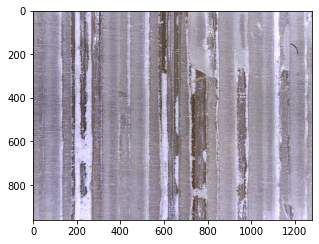

In [55]:
################################################################################
####                        Show sample image                              #####
################################################################################

img_test = imread(grinding_img_dataset.loc[:,"ImgFilepath"][90])
plt.figure(figsize=(5,5))
print(img_test.shape)
plt.imshow(img_test)

In [21]:
###########################################################################################
####        Download fast GLCM from https://github.com/tzm030329/GLCM/#readme         #####
####   code based on the algorithm in  https://ieeexplore.ieee.org/document/8803652   #####
###########################################################################################

import requests
import re

def getFilename_fromCd(cd):
    
    """
    Task: Get filename from content-disposition
    
    Argument: content-disposition
    
    Return: content filename
    """
    
    if not cd:
        return None
    fname = re.findall('filename=(.+)', cd)
    if len(fname) == 0:
        return None
    return fname[0]

glcm_master = "GLCM-master.zip"

if os.path.exists(glcm_master):
    print("GLCM already exist exists")
else:
    url = 'https://github.com/tzm030329/GLCM/archive/refs/heads/master.zip'
    r = requests.get(url, allow_redirects=True)
    filename = getFilename_fromCd(r.headers.get('content-disposition'))
    print(filename)
    open(filename, 'wb').write(r.content)
    !unzip GLCM-master.zip 
    !cp GLCM-master/fast_glcm.py fast_glcm.py
    
    
######### if google colab is being used, uncomment the next two lines    

# !git clone https://github.com/tzm030329/GLCM.git
# !cp /content/GLCM/fast_glcm.py fast_glcm.py
 


GLCM already exist exists


## **Sample GLCM images**

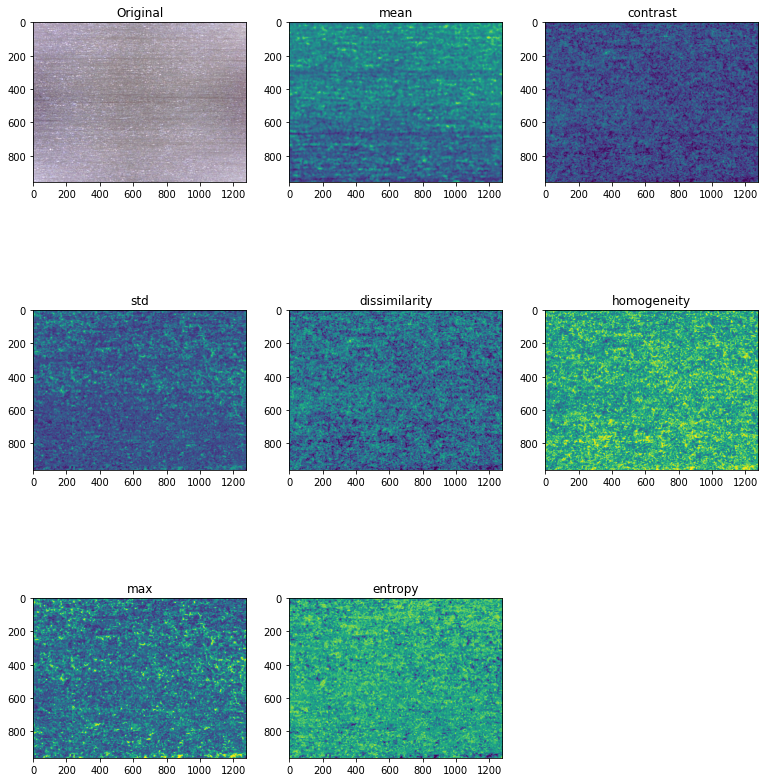

In [22]:
################################################################################
####                  Show sample GLCM images                              #####
################################################################################

from fast_glcm import *

plt.figure(num=1,figsize=(13,15))
glcm_functs = {"mean":fast_glcm_mean, "contrast":fast_glcm_contrast, "std":fast_glcm_std, "dissimilarity":fast_glcm_dissimilarity,
                  "homogeneity":fast_glcm_homogeneity, "max": fast_glcm_max, "entropy": fast_glcm_entropy }
plt.subplot(3,3,1)
plt.title("Original")
plt.imshow(img_test)
plot_count = 2
for key in glcm_functs.keys():
    plt.subplot(3,3,plot_count)
    plt.imshow(glcm_functs[key](np.resize(img_test,(img_test.shape[0],img_test.shape[1]))))
    plt.title(key)
    plot_count += 1
    
plt.show()    
    

## **Denoise image**

In [23]:
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio

estimated noise standard deviation = 1.0517999863772942


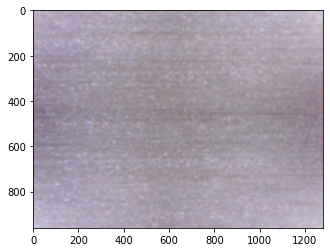

In [24]:
################################################################################
####                      Denoise GLCM images                              #####
################################################################################

patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                channel_axis=-1)

sigma_est = np.mean(estimate_sigma(img_test, channel_axis=-1))
print(f'estimated noise standard deviation = {sigma_est}')


denoise2_fast = denoise_nl_means(img_test, h=0.6 * sigma_est, sigma=sigma_est,
                                 fast_mode=True, **patch_kw)
plt.imshow(denoise2_fast)


Text(0.5, 1.0, 'Std')

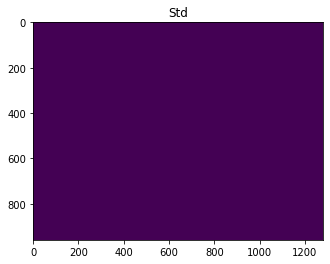

In [25]:
################################################################################
####                Show denoised GLCM images                              #####
################################################################################

plt.imshow(fast_glcm_std(np.resize(denoise2_fast,(denoise2_fast.shape[0],denoise2_fast.shape[1]))))
plt.title("Std")

## **Brighten images using Contrast Limited Adaptive Histogram Equalization**

In [26]:
import skimage.exposure as skie


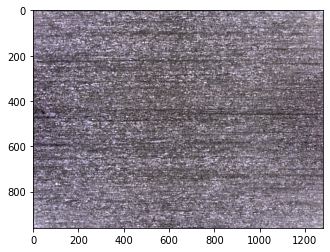

In [27]:
########################################################################################
####     Brighten images using Contrast Limited Adaptive Histogram Equalization    #####
########################################################################################

plt.imshow(skie.equalize_adapthist(img_test))



## **Utility function used for generating datasets**

In [28]:
###################################################################################
#############     Utility function used for generating datasets     ##############
##################################################################################


def generate_design_matrix(df, magnifs = False, response_var = "Ra"):
        
    """
    
    Task:   Generate the design matrix for regression.
               
    Argument:
            df: dataframe containing merged profilometer reading, metadata, and image data.
            magnifs: Choose magnification to focus on. Default to false for all magnification,
                    50 for 50X magnification and 200 for 200X magnification
            response_var: the response variable to be predicted. Defaults to Ra values
            
    Return: A tuple of response variable (target) and predictors (dataset).
            target: dataframe of response
            dataset: the X matrix
            
    """    
 
    
    if magnifs == 200 or magnifs == 50:
        df = df[df["Zoom"] == str(magnifs)]
        
    df = df.loc[:,[response_var,"ImgFilepath"]]
    dataset = pd.DataFrame()
    for pos, file in enumerate(df["ImgFilepath"]):
        if ((pos+1) % 10  == 0 or pos == len(file) - 1):
            print("Processing {0} out of {1} Grinding tool image. Filepath: {2}".format(pos + 1, df.shape[0], file))  
        if pos == 0:
            dataset = feature_extractor(file)
        else:
            f_df = feature_extractor(file)
            dataset = pd.concat([dataset,f_df], axis=0)
    print("Processed all image file and generated design matrix")
    target = df[response_var]
    return (target, dataset)


In [113]:
########################################################################################
#############     Utility functions used for generating datasets tion     ##############
########################################################################################


def img_splitter(file, num_slice_height, num_slice_width, expose): 
            
    """
    
    Task:   Split image into num_slice_height x num_slice_width.
               
    Argument:
            file: image filepath.
            num_slice_height: Number of division accros image height (vertical)
            num_slice_width: Number of division accros image width (horizontal)
            
    Return: Sliced_img_dict: A dictionary (key-value pair) of sliced image.
            key: Index of image running from 1 to num_slice_height x num_slice_width
            value: corresponding image tensor for the chosen key
            
    """ 
    
    img = imread(file)

    if expose == True: 
        img = skie.equalize_adapthist(img)
    
    (img_height, img_width, num_channels) = img.shape
    height_coord = [ii * img_height//num_slice_height for ii in range(0, num_slice_height + 1)] # generate the cutting point for the img. 
    width_coord = [ii * img_width//num_slice_width for ii in range(0, num_slice_width + 1)]
    sliced_img_dict = {}
    indx = 1
    
    for ii in range(len(height_coord)): 
        if ii == len(height_coord)-1: # dont try index index out of range
            continue
        for jj  in range(len(width_coord)):
            if jj == len(width_coord)-1:
                continue
            else:
                sliced_img_dict[indx] = img[ height_coord[ii]:height_coord[ii+1], width_coord[jj]:width_coord[jj+1], : ]
                indx += 1
    return(sliced_img_dict) 






def img_splitter_response_matcher(df, response_var, file, expose, num_slice_height = 3, num_slice_width = 4):
                
    """
    
    Task:   Match splitted image to response. If the number of unique response is less than the
            number of images, the responses is repeated until the dimension matches
               
    Argument:
            df: dataframe containing merged profilometer reading, metadata, and image data.
            response_var: the response variable to be predicted. 
            file: image filepath.
            num_slice_height: Number of division accros image height (vertical). Defaults to 3
            num_slice_width: Number of division accros image width (horizontal)). Defaults to 4
            
    Return: A tuple of response variable (target) and predictors (dataset).
            target: dataframe of response
            dataset: the X matrix
            
    """ 

    new_df = df[df["ImgFilepath"] == file]
    splitted_imgs = img_splitter(file, num_slice_height, num_slice_width, expose)
    target = np.resize(new_df[response_var], num_slice_height * num_slice_width)

    for pos in range(num_slice_height * num_slice_width):
        if pos == 0:
            dataset = GLCM_feature_extractor(splitted_imgs[pos+1], "image", expose)
        else:
            f_df = GLCM_feature_extractor(splitted_imgs[pos], "image", expose)
            dataset = pd.concat([dataset,f_df], axis=0)
    return (target, dataset)
     
    
    
    
def generate_design_matrix_using_img_split(df, magnifs = False, num_slice_height = 3, num_slice_width = 4, response_var = "Ra", light_exposure = False):
    
    """
    
    Task:   Generate the design matrix for regression using splitted images with oprion to brighten.
               
    Argument:
            df: dataframe containing merged profilometer reading, metadata, and image data.
            magnifs: Choose magnification to focus on. Default to false for all magnification,
                    50 for 50X magnification and 200 for 200X magnification
            response_var: the response variable to be predicted. Defaults to Ra values
            num_slice_height: Number of division accros image height (vertical). Defaults to 3
            num_slice_width: Number of division accros image width (horizontal)). Defaults to 4
            light_exposure: boolean to brighten 50% of the images.
            
    Return: A tuple of response variable (target) and predictors (dataset).
            target: dataframe of response
            dataset: the X matrix
            
    """   
        
    if magnifs == 200 or magnifs == 50:
        df = df[df["Zoom"] == str(magnifs)]
 
        
    df = df.loc[:,[response_var,"ImgFilepath"]]
    dataset = pd.DataFrame()
    df1 = df.loc[:,["ImgFilepath"]] # isolating only file names so we can select unique one for loop
    df1.drop_duplicates(subset=["ImgFilepath"], inplace = True)
    if light_exposure == True:
        to_expose_files = df1.sample(frac=0.5)
    else:
        to_expose_files = pd.DataFrame({"ImgFilepath":["Nothing to do"]})
        
    expose_list = []
    targets = []
    for pos, file in enumerate(df1["ImgFilepath"]):
        if to_expose_files["ImgFilepath"].str.contains(file).any():
            expose = True
        else:
            expose = False
        expose_unrolled = [expose]  * num_slice_height * num_slice_width
        if ((pos+1) % 10  == 0 or pos == len(file) - 1) or len(df) < 20 :
            print("Processing {0} out of {1} Grinding tool image. Filepath: {2}".format(pos + 1, df1.shape[0], file))  
        if pos == 0:
            res, dataset = img_splitter_response_matcher(df, response_var, file, expose)
        else:
            res, f_df = img_splitter_response_matcher(df, response_var, file, expose)
            dataset = pd.concat([dataset,f_df], axis=0)
        targets.extend(res)
        expose_list.extend(expose_unrolled)
    print("Processed all image file and generated design matrix")
    targets = pd.DataFrame({"y": targets})
    dataset["Exposure"] = expose_list
    return (targets, dataset)


            


## **GLCM Feature Extraction**

In [30]:
# importing GLCM modules
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import shannon_entropy

In [31]:
########################################################################################
#############       Utility functions for extracting GLCM feature.        ##############
########################################################################################

def GLCM_feature_extractor(img, imgOrFile = "file", expose = False):
        
    """
    
    Task:   Extract GLCM features from an image.
               
    Argument:
            img: Image tensor or image filepath.
            imgOrFile: Boolean for img is image or file. Defaults to file
            expose: Boolean to brighten image or not
            
    Return: 
           df: dataframe containing extracted GLCM features for the image.
            
    """   
        
        
    df = pd.DataFrame()
    if imgOrFile == "file":
        img = imread(img)
    else:
        pass
    if expose == True:
        img = np.resize(img, (img.shape[0], img.shape[1])).astype(np.uint8)
    else:
        img = np.resize(img, (img.shape[0], img.shape[1]))
    distance_list = [[1], [3], [5], [1], [3], [5], [1], [3], [5],[1], [3], [5]]
    angle_list = [[0],[0],[0], [np.pi/4], [np.pi/4], [np.pi/4], [np.pi/2], [np.pi/2], [np.pi/2], [np.pi*3/4], [np.pi*3/4], [np.pi*3/4]]
    glcm_features = ['energy', 'correlation', 'dissimilarity', 'homogeneity', 'contrast', 'ASM']

    for pos, val in enumerate(zip(distance_list, angle_list)):
        distance, angle = val[0], val[1]
        for feature in glcm_features:
            GLCM = graycomatrix(img, distance, angle)  
            GLCM_feature = graycoprops(GLCM, feature)[0]
            feature = feature.title() + str(pos)
            df[feature] = GLCM_feature
    entropy = shannon_entropy(img)
    df['Entropy'+ str(pos)] = entropy
            
    return df    

## **Generate dataset (Including Outliers)**

In [32]:
########################################################################################
#############       Generating unaggregated dataset with no exposure        ############
########################################################################################


# y,X = generate_design_matrix_using_img_split(df = grinding_img_dataset, num_slice_height = 3, num_slice_width = 4, response_var = "Ra", light_exposure = False)


########################################################################################
#############       Generating unaggregated dataset with exposure           ############
########################################################################################


# y,X = generate_design_matrix_using_img_split(df = grinding_img_dataset, num_slice_height = 3, num_slice_width = 4, response_var = "Ra", light_exposure = True)


########################################################################################
#############       Generating aggaggregated dataset with no exposure       ############
########################################################################################


y,X = generate_design_matrix_using_img_split(df = grinding_img_agg_dataset, num_slice_height = 3, num_slice_width = 4, response_var = "Ra", light_exposure = False)


########################################################################################
#############       Generating aggaggregated dataset with exposure          ############
########################################################################################


# y,X = generate_design_matrix_using_img_split(df = grinding_img_agg_dataset, num_slice_height = 3, num_slice_width = 4, response_var = "Ra", light_exposure = True)



Processing 10 out of 90 Grinding tool image. Filepath: Linke_Data_shared/INITIAL_3D printed_Photos_200X/0_5.jpg
Processing 20 out of 90 Grinding tool image. Filepath: Linke_Data_shared/INITIAL_3D printed_Photos_200X/15_4.jpg
Processing 30 out of 90 Grinding tool image. Filepath: Linke_Data_shared/INITIAL_3D printed_Photos_200X/90_3.jpg
Processing 40 out of 90 Grinding tool image. Filepath: Linke_Data_shared/INTERMEDIATE_PHOTOS/2_4_0_50.jpg
Processing 50 out of 90 Grinding tool image. Filepath: Linke_Data_shared/INTERMEDIATE_PHOTOS/1_2_90_50.jpg
Processing 60 out of 90 Grinding tool image. Filepath: Linke_Data_shared/Post_Test_Photos/0_3_50.jpg
Processing 70 out of 90 Grinding tool image. Filepath: Linke_Data_shared/Post_Test_Photos/15_2_200.jpg
Processing 80 out of 90 Grinding tool image. Filepath: Linke_Data_shared/Post_Test_Photos/90_1_200.jpg
Processing 90 out of 90 Grinding tool image. Filepath: Linke_Data_shared/Post_Test_Photos/90_6_50.jpg
Processed all image file and generated d

In [33]:

########################################################################################
#############             Function for plotting GLCM features               ############
########################################################################################

def EDA_plotter(X, y = 0, method = "histogram"):
            
    """
    
    Task:   Generate histograms or scatter plot of features from an image.
               
    Argument:
            X: Dataset of all extracted GLCM features.
            y: Response variable
            method: Type of plot. Defaults to histogram
            
    Return: 
           None, however, plots are displayed
            
    """   
        
        
    len_X_cols = len(X.columns)

    for i in range(0, len_X_cols,4):

        if (i+4) >= len_X_cols:
            continue
        plt.figure(figsize=(12, 3), dpi=80)

        for j in range(4):
            if method == "histogram":
                plt.subplot(1,4,j+1).hist(X[X.columns[i + j]])
            elif method == "scatter":
                plt.subplot(1,4,j+1).scatter(X[X.columns[i + j]], y)
            else:
                pass
            plt.title("{} of {}{} ".format(method, X.columns[i + j][0:3],X.columns[i + j][-1]))
        plt.show()



## **Exploratory Data Analysis**

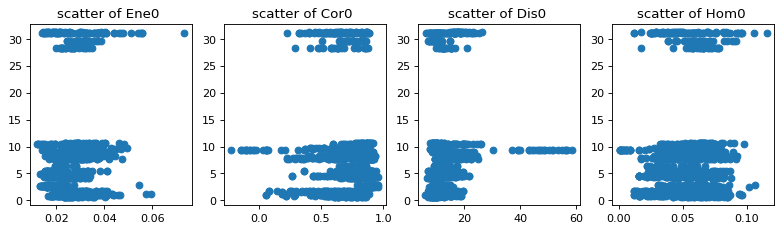

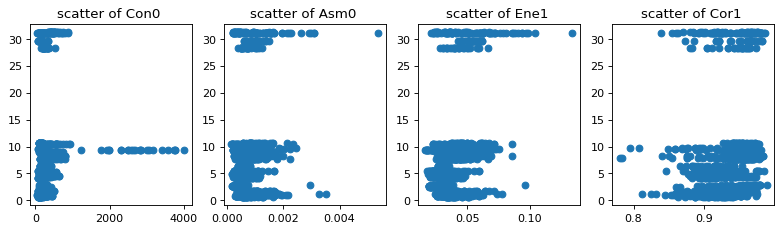

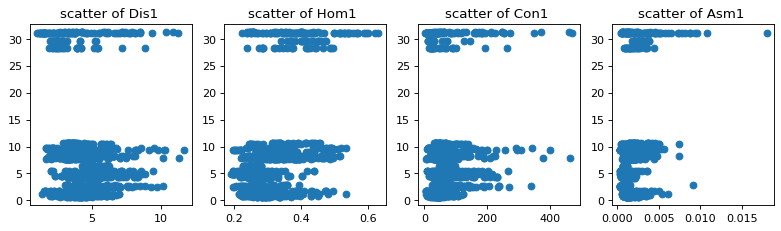

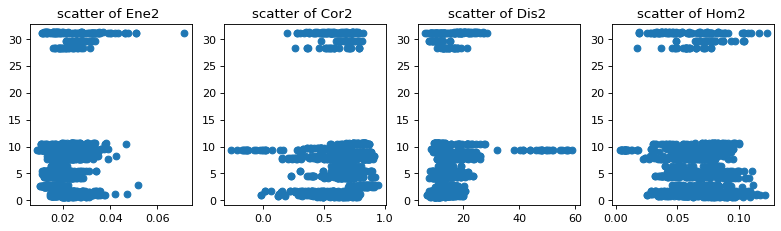

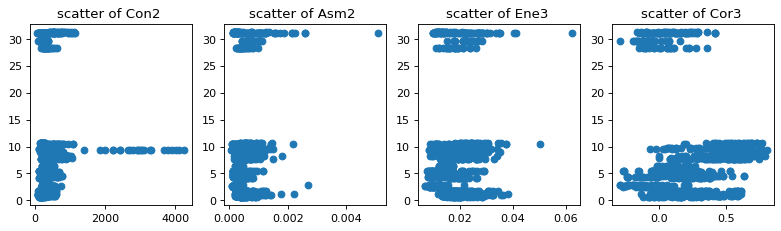

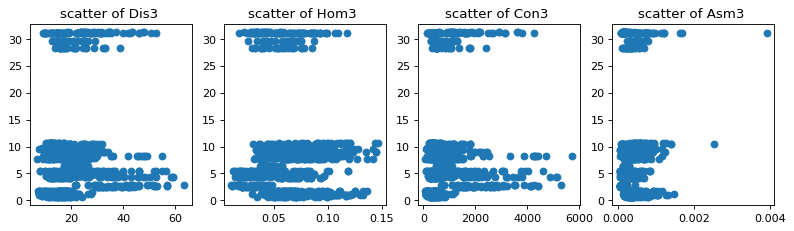

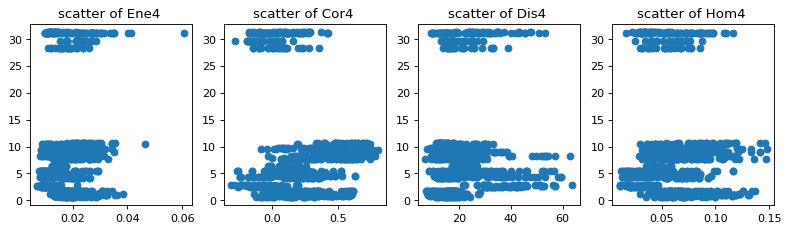

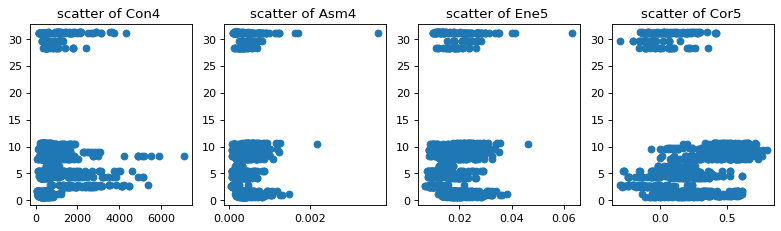

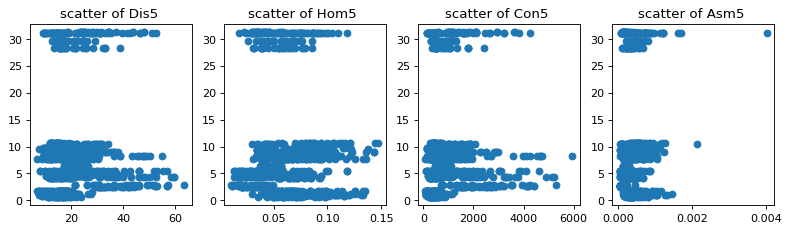

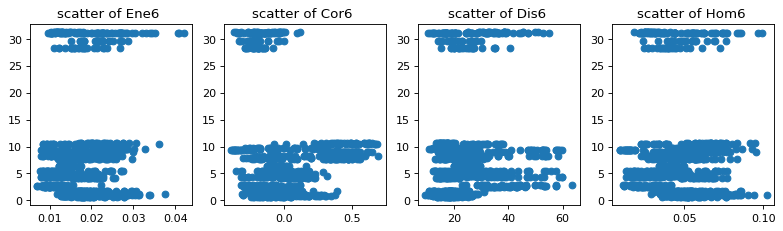

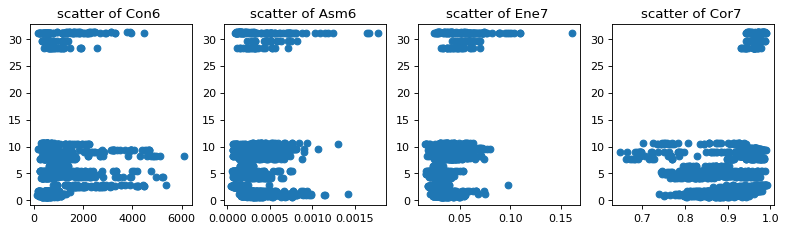

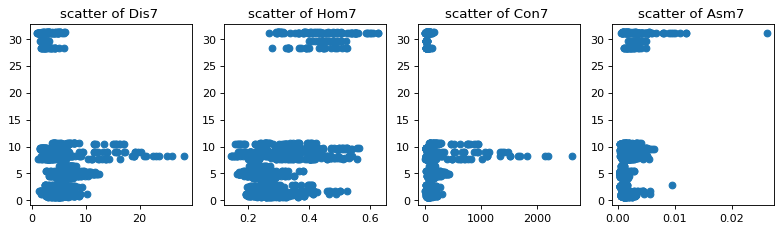

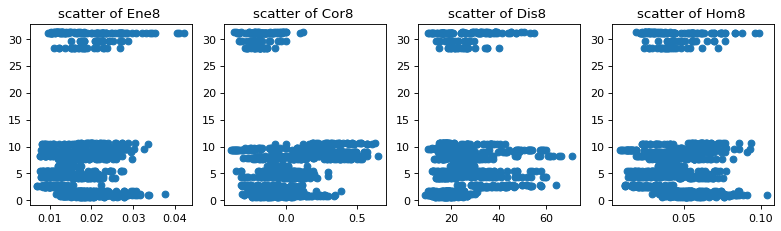

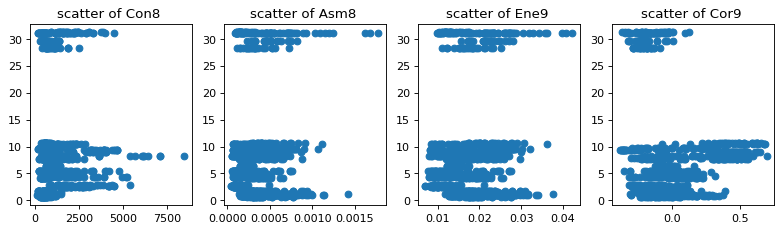

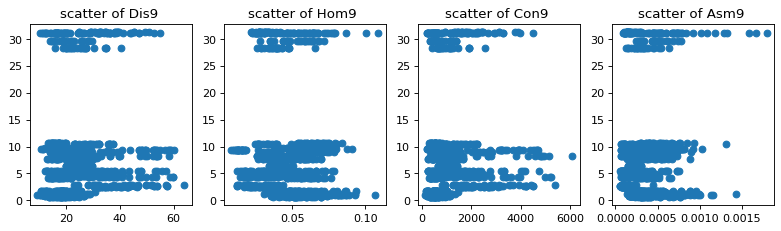

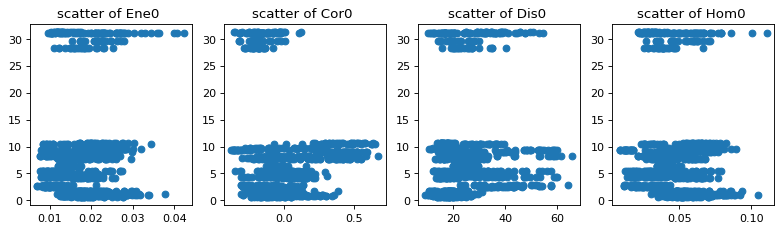

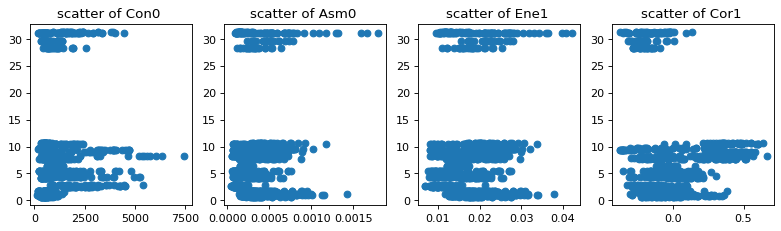

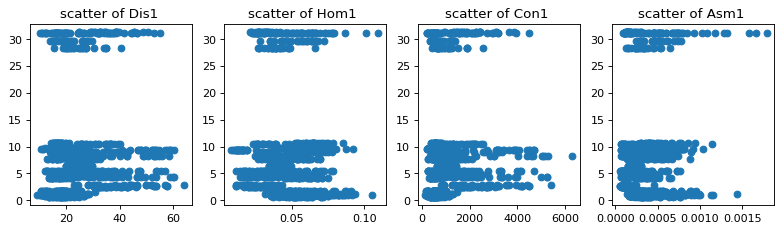

In [34]:

########################################################################################
#############             Plotting GLCM features Scatter Plots              ############
########################################################################################

EDA_plotter(X,y, method = "scatter")

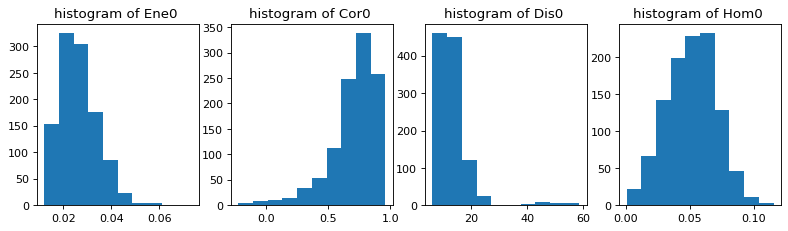

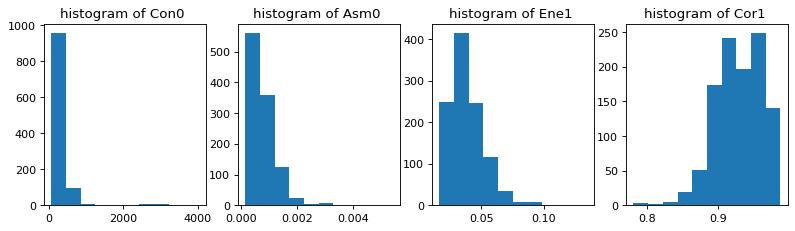

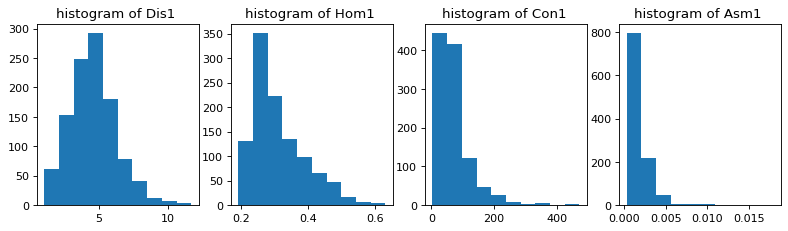

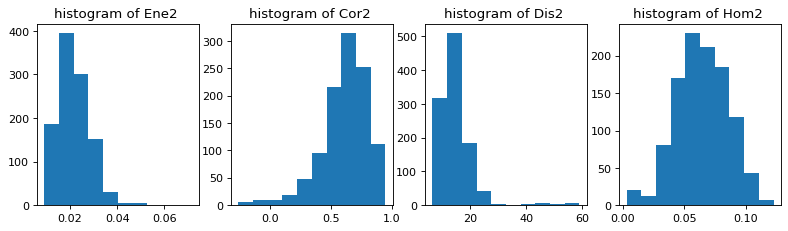

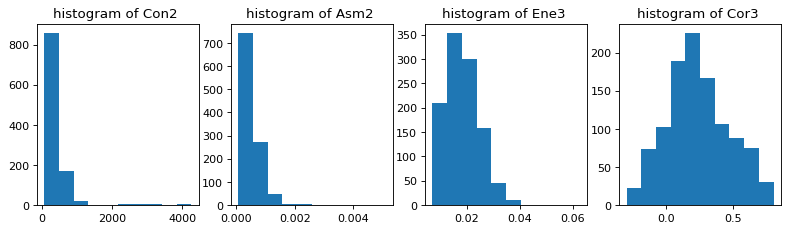

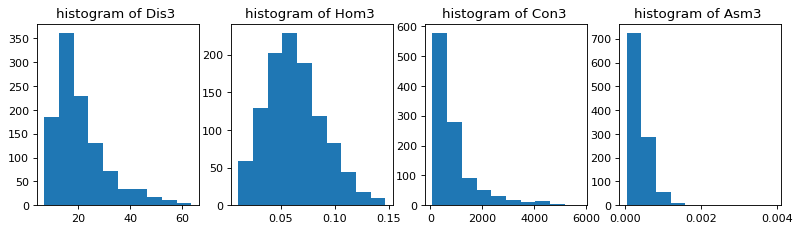

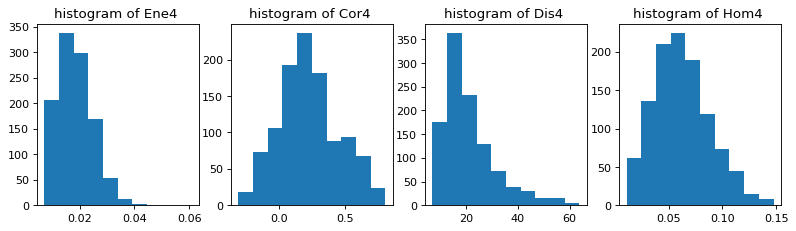

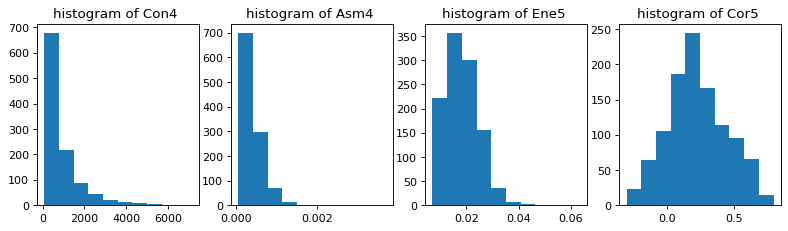

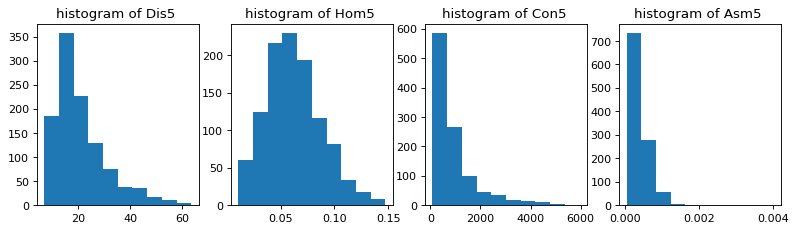

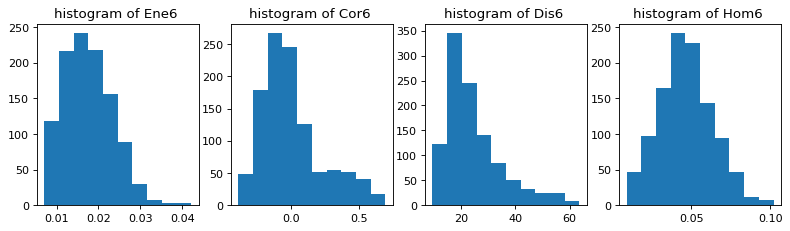

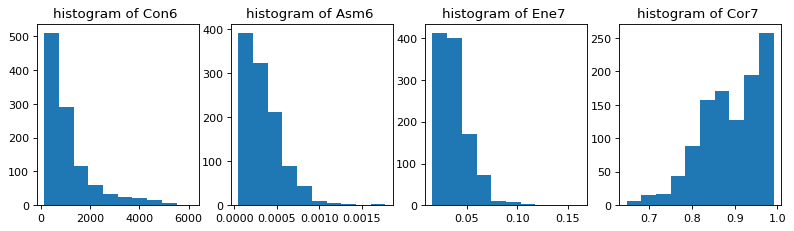

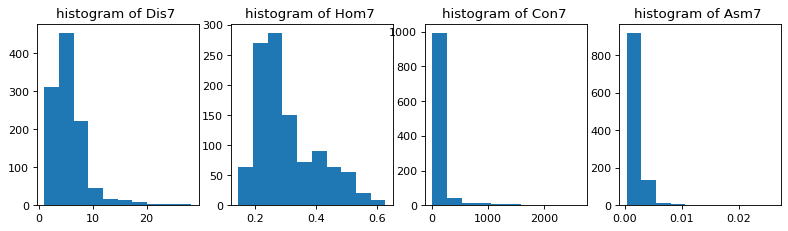

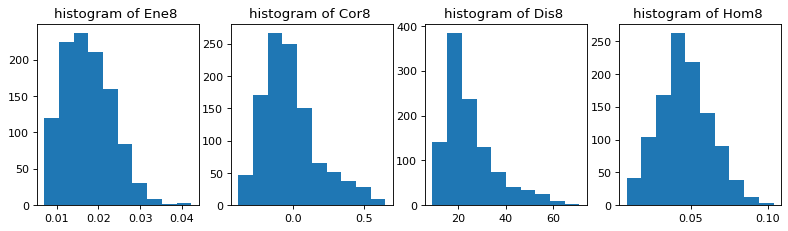

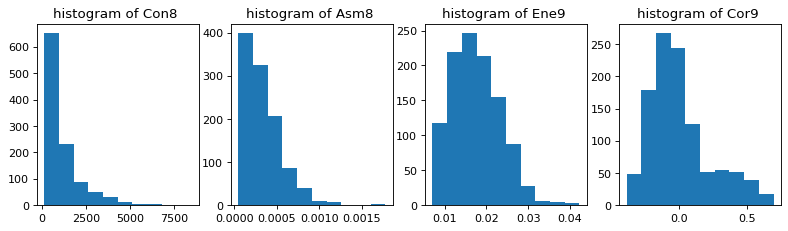

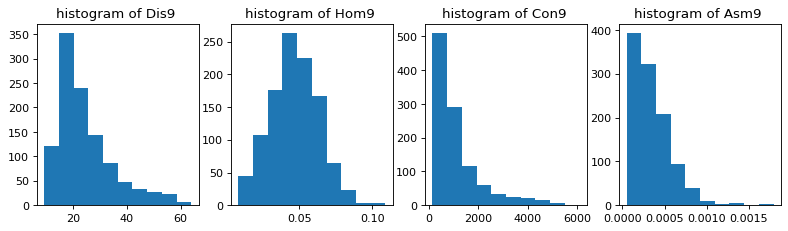

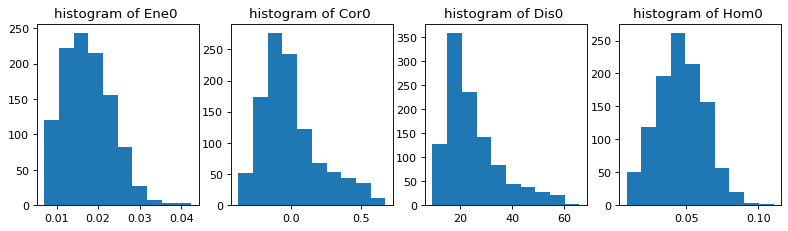

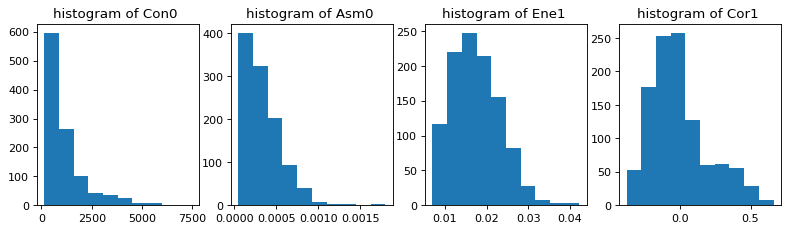

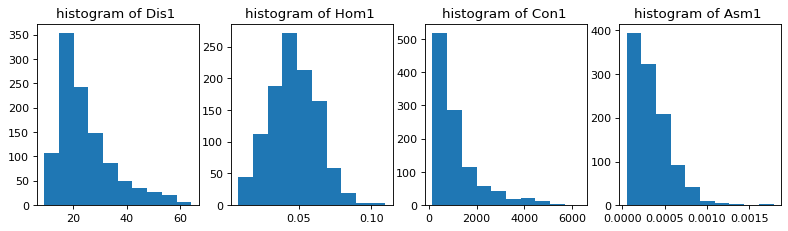

In [35]:

########################################################################################
#############               Plotting GLCM features Histograms               ############
########################################################################################

EDA_plotter(X, method = "histogram")   

In [36]:

########################################################################################
#####         Summary statistics for GLCM features and response variable          ######
########################################################################################

display(X.describe())
display(y.describe())

,Energy0,Correlation0,Dissimilarity0,Homogeneity0,Contrast0,Asm0,Energy1,Correlation1,Dissimilarity1,Homogeneity1,...,Homogeneity10,Contrast10,Asm10,Energy11,Correlation11,Dissimilarity11,Homogeneity11,Contrast11,Asm11,Entropy11
count,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,...,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000
mean,0.026343,0.701099,13.436617,0.051317,297.435439,0.000756,0.038786,0.929746,4.596037,0.313450,...,0.046517,1149.889686,0.000341,0.017581,-0.003601,24.799406,0.046557,1145.000695,0.000342,6.299616
std,0.007853,0.190304,6.299319,0.019453,413.837649,0.000481,0.013783,0.032642,1.687622,0.078995,...,0.016447,1025.248651,0.000227,0.005770,0.204582,10.428226,0.016356,992.155077,0.000227,0.503477
min,0.012037,-0.223186,6.226117,0.000524,51.419867,0.000145,0.016317,0.779995,1.046146,0.193063,...,0.008602,141.232744,0.000050,0.007038,-0.374784,9.235559,0.008116,140.346239,0.000050,5.014472
25%,0.020412,0.624563,10.065177,0.037439,141.151038,0.000417,0.028655,0.906477,3.388880,0.255151,...,0.035027,501.458595,0.000168,0.013030,-0.152889,17.394395,0.035147,504.525089,0.000170,5.921217
50%,0.025310,0.742511,12.076631,0.052875,204.941639,0.000641,0.036036,0.930701,4.522225,0.288789,...,0.046092,785.629682,0.000296,0.017187,-0.038896,21.789272,0.046133,791.538325,0.000295,6.250319
75%,0.031147,0.838243,14.872798,0.065244,304.706730,0.000970,0.045987,0.958331,5.532443,0.357734,...,0.057872,1383.049004,0.000455,0.021374,0.089641,29.209244,0.057825,1384.985091,0.000457,6.668650
max,0.073347,0.959745,58.572012,0.115617,4016.394994,0.005380,0.134038,0.988622,11.672831,0.631899,...,0.110750,7445.600876,0.001800,0.042264,0.662172,64.122346,0.109698,6321.625431,0.001786,7.549291


,y
count,1080.000000
mean,8.096270
std,9.298836
min,0.632333
25%,1.583333
50%,4.926167
75%,9.080667
max,31.242333


In [52]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import random
from sklearn.utils import shuffle


## **Custom Train-test-split [Avoid data leakage]**

In [38]:

def get_index(y, frac = 0.7):
    
    """
    
    Task:   Generate indices for subsetting data in such a way that if X50 in in test, then X200 is also in test
            Generating this way to avoid data leaking.
               
    Argument:
            y: Response variable
            frac: the percentage of data to put in the training set
            
    Return: 
           train_indx: Indices for trainin set
           test_indx: Indices for test set
            
    """   
        
        
    all_indx = [i for i in range(0,len(y))]
    even_indx = [i for i in range(0,len(y)-1,2)]
    frac_indx = round(len(even_indx) * frac)

    train_indx = random.sample(even_indx, frac_indx)
    train_indx = train_indx + [ i+1 for i in train_indx]
    test_indx = np.delete(all_indx, train_indx)
    
    return train_indx, test_indx



In [39]:


########################################################################################
#####                Removing columns with only one value                         ######
########################################################################################

print(X.shape)
cols = X.select_dtypes([np.number]).columns
std = X[cols].std()
cols_to_drop = std[std==0].index # if column has the same number then SD is 0
X = X.drop(cols_to_drop, axis=1)
print(cols_to_drop)
print(X.shape)

print(len(y))

(1080, 74)
Index([], dtype='object')
(1080, 74)
1080


## **Regression Modeling**

In [40]:

########################################################################################
#####                Fixing randomness for reproduciblitity                       ######
########################################################################################

random_state = random.sample([i for i in range(0,100)], 1)[0] ## comment out line if you want results to be fixed
random_state

61

#### **Principal Component Regression & Partial Least Squares with possibility of leaks**

In [41]:

#####################################################################################
#####    Training a Principal Component Regression & Partial Least Squares     ######
#####    Regression  model using the training set with possibility of leaks    ######
#####################################################################################

n_components = 30

y = y["y"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)

X_train, y_train = shuffle(X_train, y_train, random_state=random_state)

X_test, y_test = shuffle(X_test, y_test, random_state=random_state)


pcr = make_pipeline(StandardScaler(), PCA(n_components, whiten=True), LinearRegression())
pcr.fit(X_train, y_train)
pca = pcr.named_steps["pca"]  # retrieve the PCA step of the pipeline

pls = PLSRegression(n_components)
pls.fit(X_train, y_train)


PLSRegression(n_components=30)

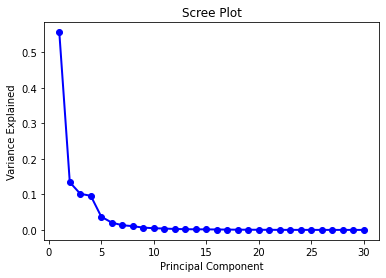

In [42]:

##########################################################
#####                   Scree Plot                  ######
##########################################################


PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

/Users/abdul-hakeemomotayo/Documents/venv/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/Users/abdul-hakeemomotayo/Documents/venv/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


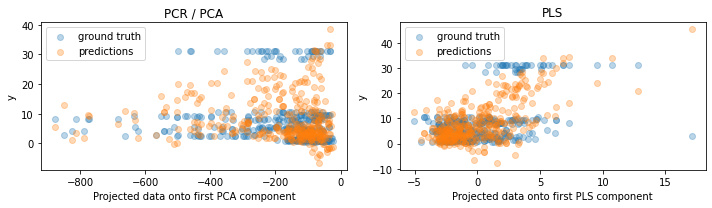

PCR out-of-sample R-squared 0.660
PLS out-of-sample R-squared 0.633

PCR out-of-sample mean squared error is 26.304990780397592 
PLS Forest out-of-sample mean squared error is 28.39418912495497 


In [43]:

#######################################################################
#####   Plotting PCR and PLS projections onto first Component   #######
#######################################################################


fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(pca.transform(X_test)[:,0], y_test, alpha=0.3, label="ground truth")
axes[0].scatter(
    pca.transform(X_test)[:,0], pcr.predict(X_test), alpha=0.3, label="predictions"
)
axes[0].set(
    xlabel="Projected data onto first PCA component", ylabel="y", title="PCR / PCA"
)
axes[0].legend()
axes[1].scatter(pls.transform(X_test)[:,0], y_test, alpha=0.3, label="ground truth")
axes[1].scatter(
    pls.transform(X_test)[:,0], pls.predict(X_test), alpha=0.3, label="predictions"
)
axes[1].set(xlabel="Projected data onto first PLS component", ylabel="y", title="PLS")
axes[1].legend()
plt.tight_layout()
plt.show()



print(f"PCR out-of-sample R-squared {pcr.score(X_test, y_test):.3f}")
print(f"PLS out-of-sample R-squared {pls.score(X_test, y_test):.3f}")

print()
y_pred = pcr.predict(X_test)
print("PCR out-of-sample mean squared error is {} ".format(mean_squared_error(y_test, y_pred)))
y_pred = pls.predict(X_test)
print("PLS Forest out-of-sample mean squared error is {} ".format(mean_squared_error(y_test, y_pred)))

#### **Principal Component Regression & Partial Least Squares with no possibility of leaks**

In [44]:

#####################################################################################
#####    Training a Principal Component Regression & Partial Least Squares     ######
#####      Regression  model using the training set without any leaks          ######
#####################################################################################


train_indx, test_indx = get_index(y, frac = 0.7)
X_train, y_train = X.iloc[train_indx], y.iloc[train_indx]
X_test, y_test = X.iloc[test_indx], y.iloc[test_indx]

X_train, y_train = shuffle(X_train, y_train, random_state= random_state)

X_test, y_test = shuffle(X_test, y_test, random_state = random_state)


pcr = make_pipeline(StandardScaler(), PCA(n_components = 30, whiten=True), LinearRegression())
pcr.fit(X_train, y_train)
pca = pcr.named_steps["pca"]  # retrieve the PCA step of the pipeline

pls = PLSRegression(n_components = 30)
pls.fit(X_train, y_train)


PLSRegression(n_components=30)

/Users/abdul-hakeemomotayo/Documents/venv/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/Users/abdul-hakeemomotayo/Documents/venv/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


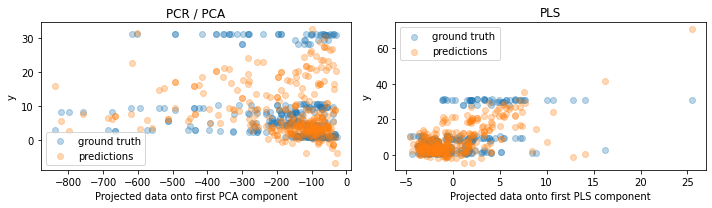

PCR out-of-sample R-squared 0.671
PLS out-of-sample R-squared 0.556

PCR out-of-sample mean squared error is 33.661091633652156 
PLS Forest out-of-sample mean squared error is 45.438672863128595 


In [45]:


#######################################################################
#####   Plotting PCR and PLS projections onto first Component   #######
#######################################################################

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(pca.transform(X_test)[:,0], y_test, alpha=0.3, label="ground truth")
axes[0].scatter(
    pca.transform(X_test)[:,0], pcr.predict(X_test), alpha=0.3, label="predictions"
)
axes[0].set(
    xlabel="Projected data onto first PCA component", ylabel="y", title="PCR / PCA"
)
axes[0].legend()
axes[1].scatter(pls.transform(X_test)[:,0], y_test, alpha=0.3, label="ground truth")
axes[1].scatter(
    pls.transform(X_test)[:,0], pls.predict(X_test), alpha=0.3, label="predictions"
)
axes[1].set(xlabel="Projected data onto first PLS component", ylabel="y", title="PLS")
axes[1].legend()
plt.tight_layout()
plt.show()


print(f"PCR out-of-sample R-squared {pcr.score(X_test, y_test):.3f}")
print(f"PLS out-of-sample R-squared {pls.score(X_test, y_test):.3f}")

print()

y_pred = pcr.predict(X_test)
print("PCR out-of-sample mean squared error is {} ".format(mean_squared_error(y_test, y_pred)))
y_pred = pls.predict(X_test)
print("PLS Forest out-of-sample mean squared error is {} ".format(mean_squared_error(y_test, y_pred)))

#### **LASSO Model**

In [46]:

#######################################################
#####                 LASSO Model               #######
#######################################################

from sklearn.linear_model import Lasso

LASSOreg = Lasso(random_state = random_state, max_iter=10000, tol=0.1, selection = 'cyclic').fit(X_train, y_train)


print("LASSO out-of-sample R-squared is {} ".format(LASSOreg.score(X_test, y_test)))
y_pred = LASSOreg.predict(X_test)
print("\nLASSO out-of-sample mean squared error is {} ".format(mean_squared_error(y_test, y_pred)))

Lasso_selected_features = [key for key,val in zip(LASSOreg.feature_names_in_, LASSOreg.coef_) if val != 0]

print(f"\nLASSO selected {len(Lasso_selected_features)} variables. They are:")
for i in Lasso_selected_features:
    print(i)

LASSO out-of-sample R-squared is 0.49189041474310546 

LASSO out-of-sample mean squared error is 52.057586318178075 

LASSO selected 14 variables. They are:
Dissimilarity0
Contrast0
Contrast2
Contrast3
Contrast4
Dissimilarity5
Contrast5
Contrast6
Dissimilarity7
Contrast7
Contrast8
Contrast9
Contrast10
Contrast11


/Users/abdul-hakeemomotayo/Documents/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.245e+03, tolerance: 5.997e+03
  model = cd_fast.enet_coordinate_descent(


#### **Decision Tree Model [CART] MODEL**

In [47]:

###############################################################
#####          Decision Tree Model [CART] MODEL         #######
###############################################################

from sklearn.tree import DecisionTreeRegressor

DTreg = DecisionTreeRegressor(max_depth = 5, random_state=random_state).fit(X_train, y_train)

print("Decision tree out-of-sample R-squared is {} ".format(DTreg.score(X_test, y_test)))
y_pred = DTreg.predict(X_test)
print("\nDecision tree out-of-sample mean squared error is {} ".format(mean_squared_error(y_test, y_pred)))

DT_selected_features = [key for key,val in zip(LASSOreg.feature_names_in_, DTreg.feature_importances_) if val != 0]

print(f"\nDecision Tree selected {len(DT_selected_features)} variables. They are:")
for i in DT_selected_features:
    print(i)

Decision tree out-of-sample R-squared is 0.3874164220583025 

Decision tree out-of-sample mean squared error is 62.76130860565294 

Decision Tree selected 20 variables. They are:
Energy0
Contrast0
Correlation1
Homogeneity1
Contrast1
Dissimilarity2
Homogeneity2
Asm2
Correlation3
Correlation4
Correlation5
Dissimilarity7
Homogeneity7
Contrast7
Asm7
Energy8
Homogeneity8
Correlation9
Correlation10
Entropy11


#### **Light Gradient Boosted Tree Model**

In [48]:

#######################################################################
#####           Light Gradient Boosted Tree Model               #######
#######################################################################

from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import GradientBoostingRegressor

from lightgbm import LGBMRegressor


LGBMreg = LGBMRegressor(max_depth = 5, random_state=random_state).fit(X_train, y_train)

print("Light Gradient boosted tree out-of-sample R-squared is {} ".format(LGBMreg.score(X_test, y_test)))
y_pred = LGBMreg.predict(X_test)
print("\nLight Gradient boosted tree out-of-sample mean squared error is {} ".format(mean_squared_error(y_test, y_pred)))

LGBM_selected_features = [key for key,val in zip(LASSOreg.feature_names_in_, LGBMreg.feature_importances_) if val != 0]

print(f"\nLight Gradient boosted tree selected {len(LGBM_selected_features)} variables. They are:")
print(LGBM_selected_features)



Light Gradient boosted tree out-of-sample R-squared is 0.6460513865447777 

Light Gradient boosted tree out-of-sample mean squared error is 36.26326098105166 

Light Gradient boosted tree selected 60 variables. They are:
['Energy0', 'Correlation0', 'Dissimilarity0', 'Homogeneity0', 'Contrast0', 'Energy1', 'Correlation1', 'Dissimilarity1', 'Homogeneity1', 'Contrast1', 'Energy2', 'Correlation2', 'Dissimilarity2', 'Homogeneity2', 'Contrast2', 'Energy3', 'Correlation3', 'Dissimilarity3', 'Homogeneity3', 'Contrast3', 'Energy4', 'Correlation4', 'Dissimilarity4', 'Homogeneity4', 'Contrast4', 'Energy5', 'Correlation5', 'Dissimilarity5', 'Homogeneity5', 'Contrast5', 'Energy6', 'Correlation6', 'Dissimilarity6', 'Homogeneity6', 'Contrast6', 'Energy7', 'Correlation7', 'Dissimilarity7', 'Homogeneity7', 'Contrast7', 'Energy8', 'Correlation8', 'Dissimilarity8', 'Homogeneity8', 'Contrast8', 'Energy9', 'Correlation9', 'Dissimilarity9', 'Homogeneity9', 'Contrast9', 'Energy10', 'Correlation10', 'Homogene

#### **Gradient Boosted Tree Model**

In [49]:

#######################################################################
#####                 Gradient Boosted Tree Model               #######
#######################################################################

from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import GradientBoostingRegressor



GBRreg = GradientBoostingRegressor(max_depth = 5, random_state=random_state).fit(X_train, y_train)

print("Gradient boosted tree out-of-sample R-squared is {} ".format(GBRreg.score(X_test, y_test)))
y_pred = GBRreg.predict(X_test)
print("\nGradient boosted tree out-of-sample mean squared error is {} ".format(mean_squared_error(y_test, y_pred)))

GBR_selected_features = [key for key,val in zip(LASSOreg.feature_names_in_, GBRreg.feature_importances_) if val != 0]

print(f"\nGradient boosted tree selected {len(GBR_selected_features)} variables. They are:")
print(GBR_selected_features)


Gradient boosted tree out-of-sample R-squared is 0.5946924327368706 

Gradient boosted tree out-of-sample mean squared error is 41.525163626943865 

Gradient boosted tree selected 73 variables. They are:
['Energy0', 'Correlation0', 'Dissimilarity0', 'Homogeneity0', 'Contrast0', 'Asm0', 'Energy1', 'Correlation1', 'Dissimilarity1', 'Homogeneity1', 'Contrast1', 'Asm1', 'Energy2', 'Correlation2', 'Dissimilarity2', 'Homogeneity2', 'Contrast2', 'Asm2', 'Energy3', 'Correlation3', 'Dissimilarity3', 'Homogeneity3', 'Contrast3', 'Asm3', 'Energy4', 'Correlation4', 'Dissimilarity4', 'Homogeneity4', 'Contrast4', 'Asm4', 'Energy5', 'Correlation5', 'Dissimilarity5', 'Homogeneity5', 'Contrast5', 'Asm5', 'Energy6', 'Correlation6', 'Dissimilarity6', 'Homogeneity6', 'Contrast6', 'Asm6', 'Energy7', 'Correlation7', 'Dissimilarity7', 'Homogeneity7', 'Contrast7', 'Asm7', 'Energy8', 'Correlation8', 'Dissimilarity8', 'Homogeneity8', 'Contrast8', 'Asm8', 'Energy9', 'Correlation9', 'Dissimilarity9', 'Homogeneity

#### **Random Forest Model**

In [50]:

#######################################################################
#####                  Random Forest Model                      #######
#######################################################################


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 4)]

max_features = ['auto', 'sqrt']

max_depth = [int(x) for x in np.linspace(10, 110, num = 3)]
max_depth.append(None)

min_samples_split = [5, 10]

min_samples_leaf = [ 2, 4]

bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

RFreg = RandomForestRegressor()

RFreg = RandomizedSearchCV(estimator = RFreg, param_distributions = random_grid, n_iter = 100,
                               cv = 5, verbose=0, random_state=random_state, n_jobs = -1).fit(X_train, y_train)


print("Random Forest out-of-sample R-squared is {} ".format(RFreg.score(X_test, y_test)))
y_pred = RFreg.predict(X_test)
print("\nRandom Forest out-of-sample mean squared error is {} ".format(mean_squared_error(y_test, y_pred)))

RFreg_selected_features = [key for key,val in zip(LASSOreg.feature_names_in_, RFreg.best_estimator_.feature_importances_) if val != 0]

print(f"\nRandom Forest tree selected {len(RFreg_selected_features)} variables. They are:")
print(RFreg_selected_features)

Random Forest out-of-sample R-squared is 0.6611615035714701 

Random Forest out-of-sample mean squared error is 34.71517717350624 

Random Forest tree selected 73 variables. They are:
['Energy0', 'Correlation0', 'Dissimilarity0', 'Homogeneity0', 'Contrast0', 'Asm0', 'Energy1', 'Correlation1', 'Dissimilarity1', 'Homogeneity1', 'Contrast1', 'Asm1', 'Energy2', 'Correlation2', 'Dissimilarity2', 'Homogeneity2', 'Contrast2', 'Asm2', 'Energy3', 'Correlation3', 'Dissimilarity3', 'Homogeneity3', 'Contrast3', 'Asm3', 'Energy4', 'Correlation4', 'Dissimilarity4', 'Homogeneity4', 'Contrast4', 'Asm4', 'Energy5', 'Correlation5', 'Dissimilarity5', 'Homogeneity5', 'Contrast5', 'Asm5', 'Energy6', 'Correlation6', 'Dissimilarity6', 'Homogeneity6', 'Contrast6', 'Asm6', 'Energy7', 'Correlation7', 'Dissimilarity7', 'Homogeneity7', 'Contrast7', 'Asm7', 'Energy8', 'Correlation8', 'Dissimilarity8', 'Homogeneity8', 'Contrast8', 'Asm8', 'Energy9', 'Correlation9', 'Dissimilarity9', 'Homogeneity9', 'Contrast9', 'As

#### **Stacked Regression**

In [51]:

#######################################################################
#####                  Stacked Regression                       #######
#######################################################################

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

estimators = [
    ("pls", pls),
    ("Decision Tree", DTreg),
    ("Gradient Boosting", GBRreg),
    ("Light Gradient Boosting", LGBMreg),
    ("Random Forest", RFreg.best_estimator_)
]

stacking_regressor = StackingRegressor(estimators = estimators, final_estimator = RidgeCV()).fit(X_train, y_train)


print("Stacked Regressor out-of-sample R-squared is {} ".format(stacking_regressor.score(X_test, y_test)))
y_pred = stacking_regressor.predict(X_test)
print("\nStacked Regressor out-of-sample mean squared error is {} ".format(mean_squared_error(y_test, y_pred)))



Stacked Regressor out-of-sample R-squared is 0.6887937886040854 

Stacked Regressor out-of-sample mean squared error is 31.88415389626066 


## Analyzing Outliers

We sought for outliers in the model and it appears there are a couple of them. The rows from 12  to 23 with all coming from the build angle of 15. We exclude these images will redo the analysis.

In [127]:
grinding_img_dataset[grinding_img_dataset["Ra"]>17]

,Capturetime,Buildangle,Facenumber,Measurementnum,Ra,Rq,Rz,Rp,Rv,Rsk,...,Rpk,Rvk,Mr1,Mr2,A1,A2,ProfileFilepath,Zoom,ImgFilepath,_merge
288,INITIAL,15,3,5,52.844,57.424,194.95,79.499,115.450,-0.079,...,1.351,43.032,0.576,61.705,0.39,823.96,Linke_Data_shared/INITIAL_PROFILOMETER_READING...,50,Linke_Data_shared/INITIAL_3D printed_Photos_50...,both
289,INITIAL,15,3,5,52.844,57.424,194.95,79.499,115.450,-0.079,...,1.351,43.032,0.576,61.705,0.39,823.96,Linke_Data_shared/INITIAL_PROFILOMETER_READING...,200,Linke_Data_shared/INITIAL_3D printed_Photos_20...,both
290,INITIAL,15,3,4,53.027,57.478,191.37,79.169,112.200,-0.098,...,1.841,53.243,0.216,59.532,0.20,1077.30,Linke_Data_shared/INITIAL_PROFILOMETER_READING...,50,Linke_Data_shared/INITIAL_3D printed_Photos_50...,both
291,INITIAL,15,3,4,53.027,57.478,191.37,79.169,112.200,-0.098,...,1.841,53.243,0.216,59.532,0.20,1077.30,Linke_Data_shared/INITIAL_PROFILOMETER_READING...,200,Linke_Data_shared/INITIAL_3D printed_Photos_20...,both
298,INITIAL,15,3,6,55.268,60.618,212.14,85.082,127.060,-0.075,...,NaN,NaN,NaN,NaN,NaN,NaN,Linke_Data_shared/INITIAL_PROFILOMETER_READING...,50,Linke_Data_shared/INITIAL_3D printed_Photos_50...,both
299,INITIAL,15,3,6,55.268,60.618,212.14,85.082,127.060,-0.075,...,NaN,NaN,NaN,NaN,NaN,NaN,Linke_Data_shared/INITIAL_PROFILOMETER_READING...,200,Linke_Data_shared/INITIAL_3D printed_Photos_20...,both
300,INITIAL,15,6,6,65.561,73.751,249.34,118.590,130.750,-0.045,...,6.592,42.181,0.840,82.485,2.77,369.40,Linke_Data_shared/INITIAL_PROFILOMETER_READING...,50,Linke_Data_shared/INITIAL_3D printed_Photos_50...,both
301,INITIAL,15,6,6,65.561,73.751,249.34,118.590,130.750,-0.045,...,6.592,42.181,0.840,82.485,2.77,369.40,Linke_Data_shared/INITIAL_PROFILOMETER_READING...,200,Linke_Data_shared/INITIAL_3D printed_Photos_20...,both
308,INITIAL,15,6,4,55.080,60.666,205.74,99.414,106.320,0.129,...,48.935,18.062,30.756,96.831,752.53,28.62,Linke_Data_shared/INITIAL_PROFILOMETER_READING...,50,Linke_Data_shared/INITIAL_3D printed_Photos_50...,both
309,INITIAL,15,6,4,55.080,60.666,205.74,99.414,106.320,0.129,...,48.935,18.062,30.756,96.831,752.53,28.62,Linke_Data_shared/INITIAL_PROFILOMETER_READING...,200,Linke_Data_shared/INITIAL_3D printed_Photos_20...,both


## **Aggregate the profilometer reading excluding outliers into a new dataframe**

In [72]:
###################################################################################################
####      Aggregate the profilometer reading excluding outliers into a new dataframe          #####
###################################################################################################

img_profilometer_data_agg = aggregate_by_img(img_profilometer_data[img_profilometer_data["Ra"]<20])

display(img_profilometer_data_agg.head())
print(img_profilometer_data_agg.shape)

Aggregated dataframe from (252, 28) to (45, 25)


Measurementnum         Ra         Rq  \
Capturetime Buildangle Facenumber                                         
INITIAL     0          1                        6  10.499167  12.731500   
                       2                        6   8.166000   9.922167   
                       3                        6   7.782333   9.464333   
                       4                        6  10.656500  12.995333   
                       5                        6   8.966833  10.759000   

                                          Rz         Rp         Rv       Rsk  \
Capturetime Buildangle Facenumber                                              
INITIAL     0          1           54.209833  26.111167  28.099167  0.005000   
                       2           42.816167  18.342667  24.473667 -0.137667   
                       3           41.082833  18.357000  22.725833 -0.022167   
                       4           56.136667  25.049833  31.087000 -0.113167   
                       5           44.188167  18.269667  25.918500 -0.376333   

                                       Rkmu         Rc         RSm  ...  \
Capturetime Buildangle Facenumber                                   ...   
INITIAL     0          1           2.420833  37.747833  651.733333  ...   
                       2           2.665000  30.423333  573.216667  ...   
                       3           2.696667  29.086833  646.416667  ...   
                       4           2.674500  45.149750  487.525000  ...   
                       5           2.408000  50.098333  265.400000  ...   

                                          Rt     Rz1max         Rk        Rpk  \
Capturetime Buildangle Facenumber                                               
INITIAL     0          1           64.669667  61.190000  34.614833  10.169333   
                       2           49.012667  48.569000  24.210333   5.486833   
                       3           48.422167  46.929000  21.564500   6.964833   
                       4           87.152167  86.141667  32.705000  13.023000   
                       5           51.705333  50.941167  26.947833   6.619500   

                                         Rvk       Mr1        Mr2         A1  \
Capturetime Buildangle Facenumber                                              
INITIAL     0          1            9.619500  9.061500  90.034167  46.680000   
                       2           11.520167  8.303333  85.054167  21.266667   
                       3           11.933167  9.325833  84.703667  29.313333   
                       4           17.150000  7.961167  86.030333  50.685000   
                       5           12.603667  6.216500  84.417833  19.380000   

                                           A2  \
Capturetime Buildangle Facenumber               
INITIAL     0          1            47.950000   
                       2           104.766667   
                       3           115.048333   
                       4           117.515000   
                       5           108.378333   

                                                                     ProfileFilepath  
Capturetime Buildangle Facenumber                                                     
INITIAL     0          1           Linke_Data_shared/INITIAL_PROFILOMETER_READING...  
                       2           Linke_Data_shared/INITIAL_PROFILOMETER_READING...  
                       3           Linke_Data_shared/INITIAL_PROFILOMETER_READING...  
                       4           Linke_Data_shared/INITIAL_PROFILOMETER_READING...  
                       5           Linke_Data_shared/INITIAL_PROFILOMETER_READING...  

[5 rows x 25 columns]

(45, 25)


In [73]:
##########################################################################################################################
####   Merge (only intersection) aggregated profilometer dataset with corresponding images. One reading per image    #####
####                          Dispay merged dataset including number of rows and columns                             #####
##########################################################################################################################

grinding_img_agg_dataset = pd.merge(left = img_profilometer_data_agg, right = img_metadata, how = "inner", on= ["Capturetime", 'Buildangle','Facenumber'], indicator = True)

display(grinding_img_agg_dataset)
print(grinding_img_agg_dataset.shape)

,Capturetime,Buildangle,Facenumber,Measurementnum,Ra,Rq,Rz,Rp,Rv,Rsk,...,Rpk,Rvk,Mr1,Mr2,A1,A2,ProfileFilepath,Zoom,ImgFilepath,_merge
0,INITIAL,0,1,6,10.499167,12.731500,54.209833,26.111167,28.099167,0.005000,...,10.169333,9.619500,9.061500,90.034167,46.680000,47.950000,Linke_Data_shared/INITIAL_PROFILOMETER_READING...,50,Linke_Data_shared/INITIAL_3D printed_Photos_50...,both
1,INITIAL,0,1,6,10.499167,12.731500,54.209833,26.111167,28.099167,0.005000,...,10.169333,9.619500,9.061500,90.034167,46.680000,47.950000,Linke_Data_shared/INITIAL_PROFILOMETER_READING...,200,Linke_Data_shared/INITIAL_3D printed_Photos_20...,both
2,INITIAL,0,2,6,8.166000,9.922167,42.816167,18.342667,24.473667,-0.137667,...,5.486833,11.520167,8.303333,85.054167,21.266667,104.766667,Linke_Data_shared/INITIAL_PROFILOMETER_READING...,50,Linke_Data_shared/INITIAL_3D printed_Photos_50...,both
3,INITIAL,0,2,6,8.166000,9.922167,42.816167,18.342667,24.473667,-0.137667,...,5.486833,11.520167,8.303333,85.054167,21.266667,104.766667,Linke_Data_shared/INITIAL_PROFILOMETER_READING...,200,Linke_Data_shared/INITIAL_3D printed_Photos_20...,both
4,INITIAL,0,3,6,7.782333,9.464333,41.082833,18.357000,22.725833,-0.022167,...,6.964833,11.933167,9.325833,84.703667,29.313333,115.048333,Linke_Data_shared/INITIAL_PROFILOMETER_READING...,50,Linke_Data_shared/INITIAL_3D printed_Photos_50...,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,POST,90,4,6,0.838833,1.102000,5.852667,2.352667,3.500000,-0.206500,...,1.549000,2.048833,10.069000,90.364833,8.115000,10.220000,Linke_Data_shared/POST_PROFILOMETER_READINGS/9...,200,Linke_Data_shared/Post_Test_Photos/90_4_200.jpg,both
86,POST,90,5,6,1.721333,2.257333,11.598000,4.633500,6.964333,-0.330500,...,2.458500,4.126167,8.879500,88.152333,10.323333,23.323333,Linke_Data_shared/POST_PROFILOMETER_READINGS/9...,200,Linke_Data_shared/Post_Test_Photos/90_5_200.jpg,both
87,POST,90,5,6,1.721333,2.257333,11.598000,4.633500,6.964333,-0.330500,...,2.458500,4.126167,8.879500,88.152333,10.323333,23.323333,Linke_Data_shared/POST_PROFILOMETER_READINGS/9...,50,Linke_Data_shared/Post_Test_Photos/90_5_50.jpg,both
88,POST,90,6,6,1.256667,1.672167,8.709167,3.441167,5.268000,-0.198167,...,3.205667,3.435000,10.631333,89.062667,19.200000,22.785000,Linke_Data_shared/POST_PROFILOMETER_READINGS/9...,200,Linke_Data_shared/Post_Test_Photos/90_6_200.jpg,both


(90, 31)


## **Descriptive statistics of aggregated dataframe**

In [128]:
################################################################################
####           Descriptive statistics of aggregated dataframe              #####
################################################################################

display(grinding_img_agg_dataset.describe())

,Measurementnum,Ra,Rq,Rz,Rp,Rv,Rsk,Rkmu,Rc,RSm,...,Rdc,Rt,Rz1max,Rk,Rpk,Rvk,Mr1,Mr2,A1,A2
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,78.000000,78.000000,...,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,5.600000,4.632652,5.741422,26.058596,11.806511,14.252107,-0.128059,3.067556,19.485920,306.081966,...,3.306107,37.278830,35.919052,13.776981,5.994819,7.489296,9.832507,88.055678,30.684630,50.880444
std,1.025517,3.098176,3.742914,16.314028,7.297556,9.152331,0.177059,0.592623,16.417604,192.049365,...,1.988498,20.821328,20.190402,9.801710,3.610959,4.533858,1.453551,2.041555,20.860817,35.993375
min,3.000000,0.632333,0.784500,3.913667,1.909833,2.003667,-0.769833,2.049667,2.254000,60.966667,...,0.531333,5.224833,4.980667,1.961667,0.895667,0.821333,6.216500,84.417833,4.991667,3.938333
25%,6.000000,1.583333,2.141167,10.135500,4.443833,5.679000,-0.198167,2.609000,4.324467,127.185000,...,1.181167,19.941000,18.694333,4.074000,2.874833,3.391833,8.799333,86.610667,15.483333,17.216667
50%,6.000000,4.513333,5.645333,23.500167,11.575667,11.969333,-0.101333,2.997500,17.197500,295.966667,...,3.508000,40.727000,39.141000,13.977500,6.404667,6.877500,9.698000,87.927333,27.406667,45.586667
75%,6.000000,7.607500,9.387500,41.145500,18.269667,23.519333,-0.028833,3.490500,32.126333,455.450000,...,4.703667,51.920500,51.247000,21.480500,8.019833,11.752333,10.696333,89.062667,41.956667,79.746667
max,6.000000,10.656500,12.995333,56.136667,26.111167,31.087000,0.218667,4.942667,52.269333,678.020000,...,7.411500,87.152167,86.141667,34.614833,18.053333,17.150000,13.137667,92.580667,105.113333,122.853333


## **Generating aggaggregated dataset with no exposure**

In [78]:
########################################################################################
#############       Generating aggaggregated dataset with no exposure       ############
########################################################################################


y,X = generate_design_matrix_using_img_split(df = grinding_img_agg_dataset, num_slice_height = 3, num_slice_width = 4, response_var = "Ra", light_exposure = False)


Processing 10 out of 90 Grinding tool image. Filepath: Linke_Data_shared/INITIAL_3D printed_Photos_200X/0_5.jpg
Processing 20 out of 90 Grinding tool image. Filepath: Linke_Data_shared/INITIAL_3D printed_Photos_200X/15_4.jpg
Processing 30 out of 90 Grinding tool image. Filepath: Linke_Data_shared/INITIAL_3D printed_Photos_200X/90_3.jpg
Processing 40 out of 90 Grinding tool image. Filepath: Linke_Data_shared/INTERMEDIATE_PHOTOS/2_4_0_50.jpg
Processing 50 out of 90 Grinding tool image. Filepath: Linke_Data_shared/INTERMEDIATE_PHOTOS/1_2_90_50.jpg
Processing 60 out of 90 Grinding tool image. Filepath: Linke_Data_shared/Post_Test_Photos/0_3_50.jpg
Processing 70 out of 90 Grinding tool image. Filepath: Linke_Data_shared/Post_Test_Photos/15_2_200.jpg
Processing 80 out of 90 Grinding tool image. Filepath: Linke_Data_shared/Post_Test_Photos/90_1_200.jpg
Processing 90 out of 90 Grinding tool image. Filepath: Linke_Data_shared/Post_Test_Photos/90_6_50.jpg
Processed all image file and generated d

## **Plotting GLCM features Scatter Plots**

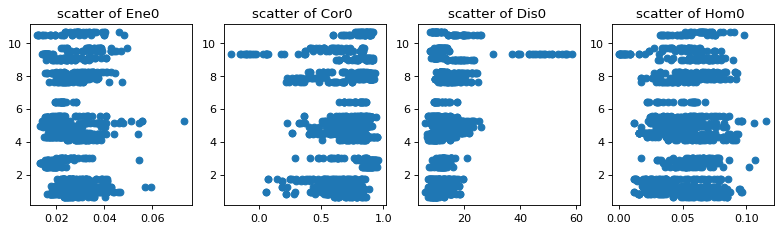

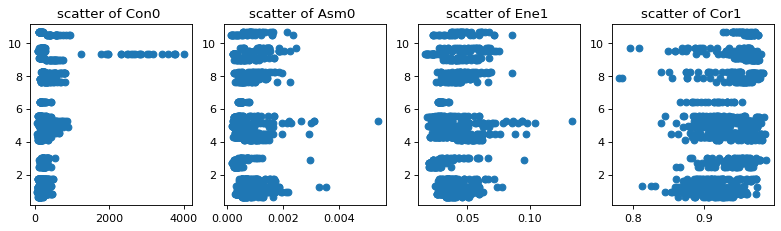

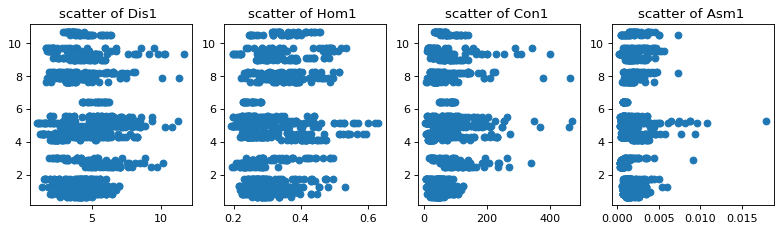

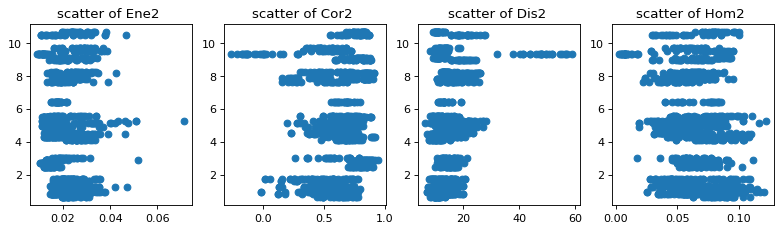

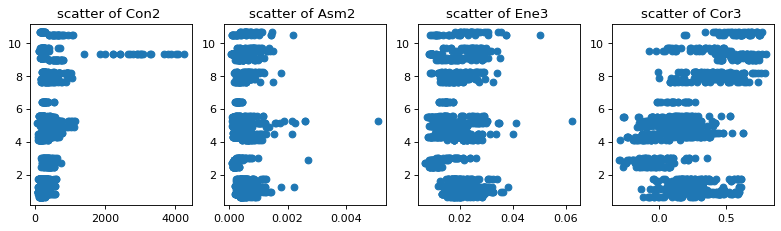

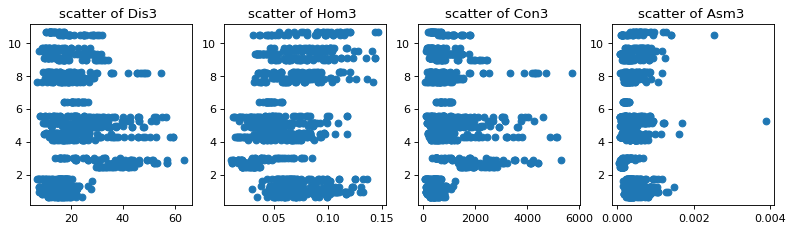

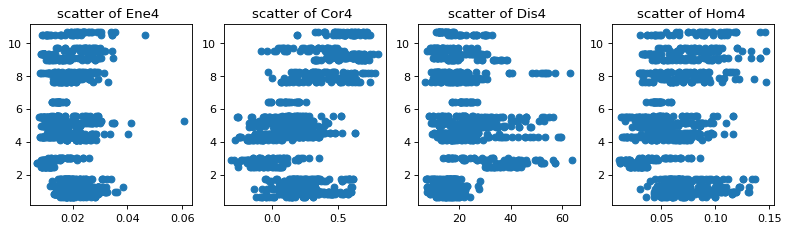

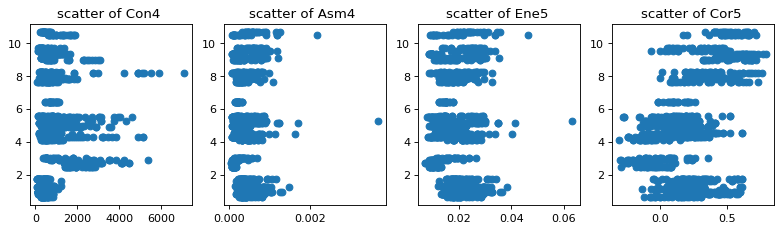

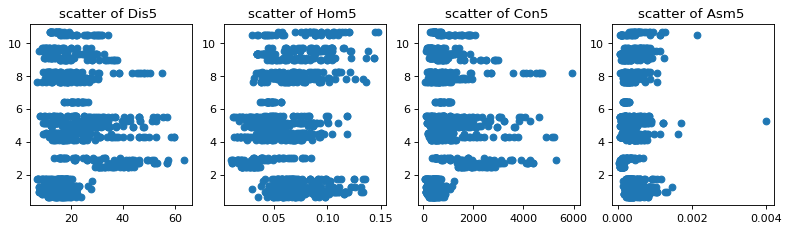

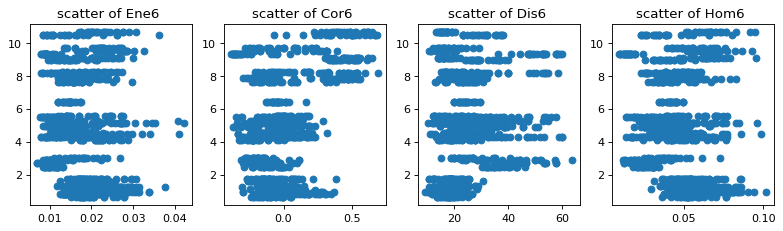

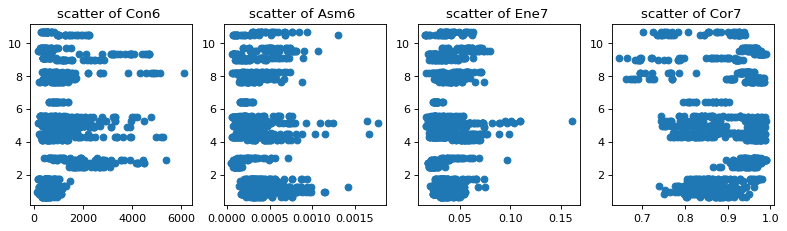

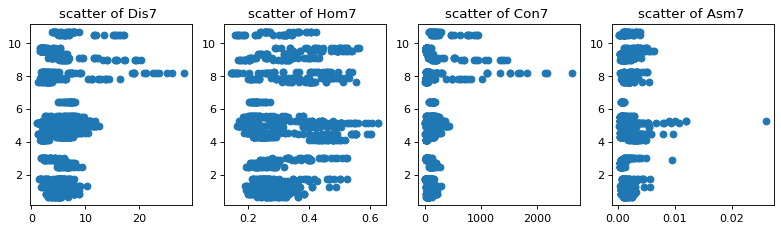

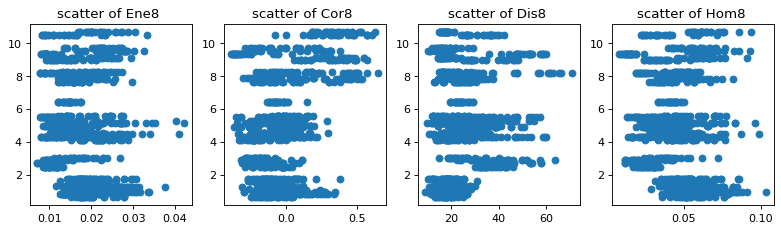

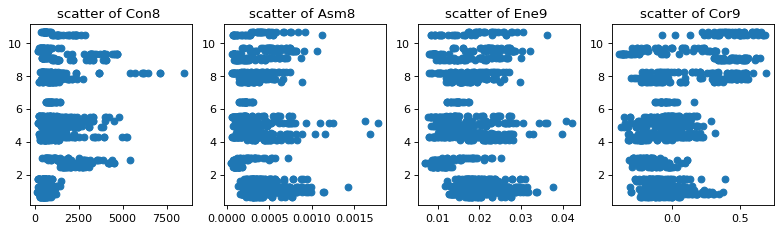

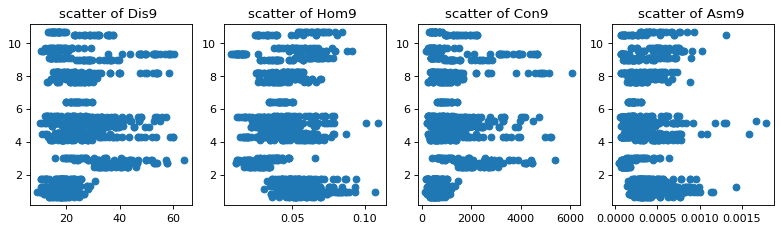

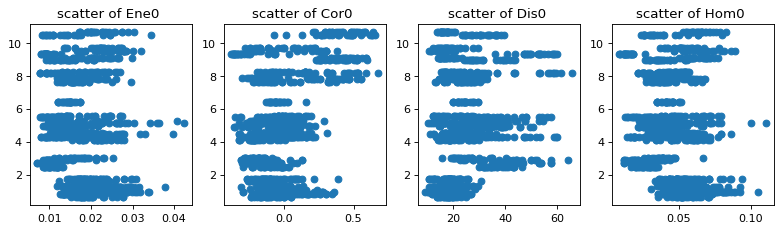

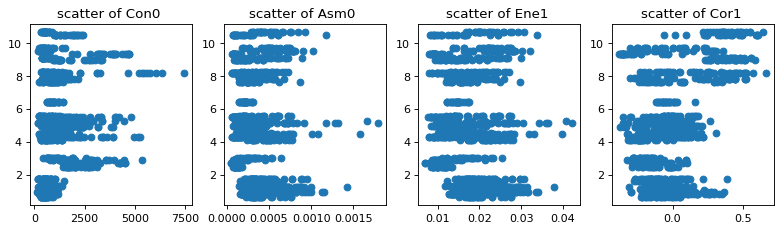

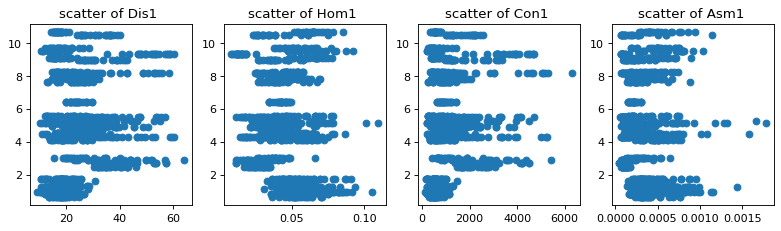

In [77]:

########################################################################################
#############             Plotting GLCM features Scatter Plots              ############
########################################################################################

# EDA_plotter(X,y, method = "scatter")

## **Regression  Modeling**

#### **Principal Component Regression & Partial Least Squares**

/Users/abdul-hakeemomotayo/Documents/venv/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/Users/abdul-hakeemomotayo/Documents/venv/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


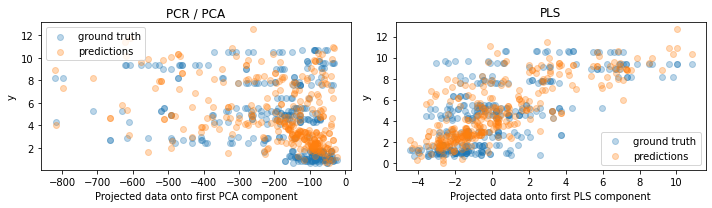

PCR out-of-sample R-squared 0.712
PLS out-of-sample R-squared 0.705

PCR out-of-sample mean squared error is 2.8931832030476463 
PLS Forest out-of-sample mean squared error is 2.9634545574377946 


In [83]:

#####################################################################################
#####    Training a Principal Component Regression & Partial Least Squares     ######
#####      Regression  model using the training set without any leaks          ######
#####################################################################################

y = y["y"]
train_indx, test_indx = get_index(y, frac = 0.7)
X_train, y_train = X.iloc[train_indx], y.iloc[train_indx]
X_test, y_test = X.iloc[test_indx], y.iloc[test_indx]

X_train, y_train = shuffle(X_train, y_train, random_state= random_state)

X_test, y_test = shuffle(X_test, y_test, random_state = random_state)


pcr = make_pipeline(StandardScaler(), PCA(n_components = 30, whiten=True), LinearRegression())
pcr.fit(X_train, y_train)
pca = pcr.named_steps["pca"]  # retrieve the PCA step of the pipeline

pls = PLSRegression(n_components = 30)
pls.fit(X_train, y_train)



#######################################################################
#####   Plotting PCR and PLS projections onto first Component   #######
#######################################################################

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(pca.transform(X_test)[:,0], y_test, alpha=0.3, label="ground truth")
axes[0].scatter(
    pca.transform(X_test)[:,0], pcr.predict(X_test), alpha=0.3, label="predictions"
)
axes[0].set(
    xlabel="Projected data onto first PCA component", ylabel="y", title="PCR / PCA"
)
axes[0].legend()
axes[1].scatter(pls.transform(X_test)[:,0], y_test, alpha=0.3, label="ground truth")
axes[1].scatter(
    pls.transform(X_test)[:,0], pls.predict(X_test), alpha=0.3, label="predictions"
)
axes[1].set(xlabel="Projected data onto first PLS component", ylabel="y", title="PLS")
axes[1].legend()
plt.tight_layout()
plt.show()


print(f"PCR out-of-sample R-squared {pcr.score(X_test, y_test):.3f}")
print(f"PLS out-of-sample R-squared {pls.score(X_test, y_test):.3f}")

print()

y_pred = pcr.predict(X_test)
print("PCR out-of-sample mean squared error is {} ".format(mean_squared_error(y_test, y_pred)))
y_pred = pls.predict(X_test)
print("PLS Forest out-of-sample mean squared error is {} ".format(mean_squared_error(y_test, y_pred)))

#### **LASSO Model**

In [84]:

#######################################################
#####                 LASSO Model               #######
#######################################################

from sklearn.linear_model import LassoCV, Lasso

LASSOreg = LassoCV(random_state = random_state, max_iter=10000, tol=0.1, selection = 'cyclic').fit(X_train, y_train)


print("LASSO out-of-sample R-squared is {} ".format(LASSOreg.score(X_test, y_test)))
y_pred = LASSOreg.predict(X_test)
print("\nLASSO out-of-sample mean squared error is {} ".format(mean_squared_error(y_test, y_pred)))

Lasso_selected_features = [key for key,val in zip(LASSOreg.feature_names_in_, LASSOreg.coef_) if val != 0]

print(f"\nLASSO selected {len(Lasso_selected_features)} variables. They are:")
for i in Lasso_selected_features:
    print(i)

LASSO out-of-sample R-squared is 0.29661511925855233 

LASSO out-of-sample mean squared error is 7.072759911664847 

LASSO selected 12 variables. They are:
Contrast2
Dissimilarity3
Contrast3
Contrast4
Contrast5
Contrast6
Dissimilarity7
Contrast7
Contrast8
Contrast9
Contrast10
Contrast11


#### **Decision Tree Model [CART] MODEL**

In [85]:

###############################################################
#####          Decision Tree Model [CART] MODEL         #######
###############################################################

from sklearn.tree import DecisionTreeRegressor

DTreg = DecisionTreeRegressor(max_depth = 5, random_state=random_state).fit(X_train, y_train)

print("Decision tree out-of-sample R-squared is {} ".format(DTreg.score(X_test, y_test)))
y_pred = DTreg.predict(X_test)
print("\nDecision tree out-of-sample mean squared error is {} ".format(mean_squared_error(y_test, y_pred)))

DT_selected_features = [key for key,val in zip(LASSOreg.feature_names_in_, DTreg.feature_importances_) if val != 0]

print(f"\nDecision Tree selected {len(DT_selected_features)} variables. They are:")
for i in DT_selected_features:
    print(i)

Decision tree out-of-sample R-squared is 0.5354825049657989 

Decision tree out-of-sample mean squared error is 4.670871960855435 

Decision Tree selected 20 variables. They are:
Correlation0
Contrast0
Homogeneity1
Contrast1
Energy2
Correlation2
Asm2
Correlation4
Homogeneity5
Correlation6
Correlation7
Dissimilarity7
Homogeneity7
Correlation8
Correlation9
Homogeneity9
Homogeneity10
Contrast10
Correlation11
Contrast11


#### **Gradient Boosted Tree Model**

In [92]:

#######################################################################
#####                 Gradient Boosted Tree Model               #######
#######################################################################

max_depth = [int(x) for x in np.linspace(10, 110, num = 3)]
max_depth.append(5)

random_grid = {
    "n_estimators": [int(x) for x in np.linspace(start = 200, stop = 2000, num = 4)],
    "max_depth": max_depth,
    "min_samples_split": [5, 10],
    "learning_rate": [0.01],
    "loss": ["squared_error"],
}



GBRreg = RandomizedSearchCV(estimator = GradientBoostingRegressor(), param_distributions = random_grid, n_iter = 1000,
                               cv = 5, verbose=0, random_state=random_state, n_jobs = -1).fit(X_train, y_train)


print("Gradient boosted tree out-of-sample R-squared is {} ".format(GBRreg.score(X_test, y_test)))
y_pred = GBRreg.predict(X_test)
print("\nGradient boosted tree out-of-sample mean squared error is {} ".format(mean_squared_error(y_test, y_pred)))

GBR_selected_features = [key for key,val in zip(LASSOreg.feature_names_in_, GBRreg.best_estimator_.feature_importances_) if val != 0]

print(f"\nGradient boosted tree selected {len(GBR_selected_features)} variables. They are:")
print(GBR_selected_features)


Gradient boosted tree out-of-sample R-squared is 0.7517211271794848 

Gradient boosted tree out-of-sample mean squared error is 2.496523463437589 

Gradient boosted tree selected 73 variables. They are:
['Energy0', 'Correlation0', 'Dissimilarity0', 'Homogeneity0', 'Contrast0', 'Asm0', 'Energy1', 'Correlation1', 'Dissimilarity1', 'Homogeneity1', 'Contrast1', 'Asm1', 'Energy2', 'Correlation2', 'Dissimilarity2', 'Homogeneity2', 'Contrast2', 'Asm2', 'Energy3', 'Correlation3', 'Dissimilarity3', 'Homogeneity3', 'Contrast3', 'Asm3', 'Energy4', 'Correlation4', 'Dissimilarity4', 'Homogeneity4', 'Contrast4', 'Asm4', 'Energy5', 'Correlation5', 'Dissimilarity5', 'Homogeneity5', 'Contrast5', 'Asm5', 'Energy6', 'Correlation6', 'Dissimilarity6', 'Homogeneity6', 'Contrast6', 'Asm6', 'Energy7', 'Correlation7', 'Dissimilarity7', 'Homogeneity7', 'Contrast7', 'Asm7', 'Energy8', 'Correlation8', 'Dissimilarity8', 'Homogeneity8', 'Contrast8', 'Asm8', 'Energy9', 'Correlation9', 'Dissimilarity9', 'Homogeneity9

#### **Random Forest Model**

In [88]:

#######################################################################
#####                  Random Forest Model                      #######
#######################################################################


n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 4)]

max_features = ['auto', 'sqrt']

max_depth = [int(x) for x in np.linspace(10, 110, num = 3)]
max_depth.append(None)

min_samples_split = [5, 10]

min_samples_leaf = [ 2, 4]

bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

RFreg = RandomForestRegressor()

RFreg = RandomizedSearchCV(estimator = RFreg, param_distributions = random_grid, n_iter = 100,
                               cv = 5, verbose=0, random_state=random_state, n_jobs = -1).fit(X_train, y_train)


print("Random Forest out-of-sample R-squared is {} ".format(RFreg.score(X_test, y_test)))
y_pred = RFreg.predict(X_test)
print("\nRandom Forest out-of-sample mean squared error is {} ".format(mean_squared_error(y_test, y_pred)))

RFreg_selected_features = [key for key,val in zip(LASSOreg.feature_names_in_, RFreg.best_estimator_.feature_importances_) if val != 0]

print(f"\nRandom Forest tree selected {len(RFreg_selected_features)} variables. They are:")
print(RFreg_selected_features)

Random Forest out-of-sample R-squared is 0.7236698821773464 

Random Forest out-of-sample mean squared error is 2.7785877024560306 

Random Forest tree selected 73 variables. They are:
['Energy0', 'Correlation0', 'Dissimilarity0', 'Homogeneity0', 'Contrast0', 'Asm0', 'Energy1', 'Correlation1', 'Dissimilarity1', 'Homogeneity1', 'Contrast1', 'Asm1', 'Energy2', 'Correlation2', 'Dissimilarity2', 'Homogeneity2', 'Contrast2', 'Asm2', 'Energy3', 'Correlation3', 'Dissimilarity3', 'Homogeneity3', 'Contrast3', 'Asm3', 'Energy4', 'Correlation4', 'Dissimilarity4', 'Homogeneity4', 'Contrast4', 'Asm4', 'Energy5', 'Correlation5', 'Dissimilarity5', 'Homogeneity5', 'Contrast5', 'Asm5', 'Energy6', 'Correlation6', 'Dissimilarity6', 'Homogeneity6', 'Contrast6', 'Asm6', 'Energy7', 'Correlation7', 'Dissimilarity7', 'Homogeneity7', 'Contrast7', 'Asm7', 'Energy8', 'Correlation8', 'Dissimilarity8', 'Homogeneity8', 'Contrast8', 'Asm8', 'Energy9', 'Correlation9', 'Dissimilarity9', 'Homogeneity9', 'Contrast9', 'A

#### **Stacked Regression**

In [93]:

#######################################################################
#####                  Stacked Regression                       #######
#######################################################################

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

estimators = [
    ("pls", pls),
    ("Decision Tree", DTreg),
    ("Gradient Boosting", GBRreg.best_estimator_),
    ("Random Forest", RFreg.best_estimator_)
]

stacking_regressor = StackingRegressor(estimators = estimators, final_estimator = RidgeCV()).fit(X_train, y_train)


print("Stacked Regressor out-of-sample R-squared is {} ".format(stacking_regressor.score(X_test, y_test)))
y_pred = stacking_regressor.predict(X_test)
print("\nStacked Regressor out-of-sample mean squared error is {} ".format(mean_squared_error(y_test, y_pred)))



Stacked Regressor out-of-sample R-squared is 0.7807504062038745 

Stacked Regressor out-of-sample mean squared error is 2.2046247795594134 


## **Prediction Endpoint**

In [123]:

#######################################################################
#####                  Prediction Endpoint                       ######
#######################################################################


def get_prediction(folder_path = "Linke_Prediction", method = stacking_regressor):
        
    """
    
    Task:   Predict the response for image (jpg) in folder_path .
               
    Argument:
            folder_path (str): The folder containing the images for prediction.
                               Defaults to Linke_Prediction.
            
    Return: 
            df (pd Dataframe): dataframe of filepath and the corresponding prediction

            
    """ 
    folder_path += "/*.jpg"
    
    filepaths = glob(folder_path, recursive=True)
    fake_response = [i for i in range(len(filepaths))]
    img_metadata = pd.DataFrame({"ImgFilepath": filepaths, "fakeResponse": fake_response})
    top_level = folder_path.split("/")[0]
    print(f"\nFound {len(img_metadata)} files for prediction in {top_level} folder\n")
    
    
    num_slice_height = 3
    num_slice_width = 4
    indx,new_X = generate_design_matrix_using_img_split(df = img_metadata, num_slice_height = num_slice_height,
                                                 num_slice_width = num_slice_width, response_var = "fakeResponse", light_exposure = False)
    y_pred = stacking_regressor.predict(new_X)
    final_pred = []
    for count, filepath in enumerate(filepaths):
        
        if len(filepaths) == 1:
            
            final_pred.append(np.mean(y_pred))         

        start_indx = num_slice_height * num_slice_width * (count)
        end_indx = num_slice_height * num_slice_width * (count + 1)
        temp_pred = np.mean(y_pred[start_indx:end_indx])
        final_pred.append(temp_pred)
    df = pd.DataFrame({"Filepath":filepaths, "Prediction": final_pred})
    return(df)
 

## Sample usage of prediction endpoint

In [124]:

#######################################################################
#####          Sample usage of prediction endpoint               ######
#######################################################################

get_prediction("Linke_Prediction")


Found 3 files for prediction in Linke_Prediction folder

Processing 1 out of 3 Grinding tool image. Filepath: Linke_Prediction/2_3_15_50.jpg
Processing 2 out of 3 Grinding tool image. Filepath: Linke_Prediction/2_3_0_200.jpg
Processing 3 out of 3 Grinding tool image. Filepath: Linke_Prediction/2_3_0_50.jpg
Processed all image file and generated design matrix


,Filepath,Prediction
0,Linke_Prediction/2_3_15_50.jpg,5.266526
1,Linke_Prediction/2_3_0_200.jpg,4.284304
2,Linke_Prediction/2_3_0_50.jpg,4.860901
